**Webpage: [https://v993.github.io/Representative-Polarity-US-House/](https://v993.github.io/Representative-Polarity-US-House/)**

<img src="images/ai_congress.jpg" alt="drawing" width="1500" align="center"/>

# Problem Overview:
***

U.S. politics have increasingly become more polarized and complicated in recent decades, a major focal point of today's political science. For many, this is cause for concern- and not only because of its impact on Thanksgiving dinners. Pernicious polarization has been linked to democratic erosion (Carnegie), and as the fastest polarizing country in the world (Brown), we as constituents have a responsibility to question what our representatives' motives are, and whether they have our best interests at heart. So what are our responsibilities? Many of us understand the importance of voting, but how can we keep track of what decisions our representatives are making for us, and whether or not we should vote for them down again the line? As important as voting is in the U.S., many of us have better things to do than endlessly scrutinize the representative we voted for because they were blue or red in that election that felt like yesterday, and yet, is somehow happening again, urging you out of your house and ruining your Tuesday afternoon.

Quantification of a representative on an ideological plane allows us to summarize who a representative is without studying their voting patterns or past policies. We can tell a lot about a representative by comparing them to their peers and contextualizing their ideology in relation to others. It would be a lot easier to say that a person is quantifiably -0.7 on an ideological scale compared to their colleagues than it would be to summarize the legislative decisions they have made.

Furthermore, it is by no means a new idea to conceptualize politicians in multidimensional space in order to understand their political ideology. Famously, Poole and Rosenthal estimate spatial coordinates for representatives using political choices: _votes_*. Poole and Rosenthal's DW-NOMINATE system (Dynamic Weighted NOMINAI-Three-step-Estimation) represents legislators in two-dimensional map showing how similar their voting records are, and theoretically, their political ideologies. This also means that the means by which we may compute a representative's position in this space are still confined to those politicians who we know through voting records. New representatives who have never voted obviously cannot have a NOMINATE score. 

Understanding a candidate's place in the context of their fellow representatives could be a useful tool toward understanding where politicians lie (no pun intended), and how they can be quantified- prior to election. In this project, I hope to use data on political representatives and the districts they represent to quantify their political ideologies and predict NOMINATE scores without using voting records. The main goal of this project is to make large-scale politics more digestible. I've done some work on this in the past ([New York Data Project](https://github.com/V993/LegislativeDataAnalytics)) but never in a learning capacity (i.e. machine learning). My work will be centered in this [website](https://v993.github.io/). I will focus specifically on House representatives. There are more representatives to train on, and I believe we will encounter more variance on a lower level of congress.

<br />

**The central questions which will guide this study are the following**:
- Are data on representatives alone adequate to predict NOMINATE scores?
- What features of a representative have the largest impact on their ideology?

<br />

Citations:
* [Carnegie](https://carnegieendowment.org/2022/01/18/what-happens-when-democracies-become-perniciously-polarized-pub-86190), “What Happens When Democracies Become Perniciously Polarized?
* [Brown](https://www.brown.edu/news/2020-01-21/polarization), “U.S. is Polarizing Faster Than Other Democracies”
* *Poole, Keith T., and Howard Rosenthal. “[A Spatial Model for Legislative Roll Call Analysis](https://www.jstor.org/stable/2111172).” American Journal of Political Science, vol. 29, no. 2, 1985, pp. 357–84. JSTOR

In [1]:
# load pretty jupyter
%load_ext pretty_jupyter

In [2]:
%%capture
%pip install numpy pandas thefuzz matplotlib importlib

In [3]:
import re
import math
import requests
import geopandas
import numpy as np
import pandas as pd
from io import StringIO
from thefuzz import fuzz
from math import floor, ceil
from bs4 import BeautifulSoup
from fuzzywuzzy import process
import matplotlib.pyplot as plt

# plt.rcParams['axes.grid'] = True # Universal grids for plots
plt.rcParams.update({'font.size': 22}) # Universal font size for plots

# Set facecolor for plots, best for exporting
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Data/Resources:
***

In order to understand representatives ideology without their voting records, we're going to need some good substitutes. To cover our bases, I've pulled data for a representative's constituents and as much data on the representative I could find. 

**Representative Data:**

The best sources of data on representatives that aren't vote-oriented are finance data, as all representatives are required by law to report their campaign and personal finances to the FEC. Two important sources of data here are OpenSecrets, which is a nonpartisan organization which tracks money in politics, and the FEC, from which some of the OpenSecrets data is collected. 

1. [VoteView](https://voteview.com/data) DW-NOMINATE scores of representatives in the house of congress
2. [OpenSecrets](https://www.opensecrets.org/) data on lobbying, campaign finance, and personal finances for congressional representatives
3. [FEC](https://www.fec.gov/campaign-finance-data/congressional-candidate-data-summary-tables/?year=2018&segment=24) campaign finance data for congressional representatives


**State Demographics:**

A primary concern (at least it should be a primary concern) for representatives are their constituents. Constituents decide who holds public office, and this often attracts a particular person to represent a particular district. Using demographic data of a representative's constituents can give us vital insight into the ideology of the representative. Furthermore, state data is easier to find than data on representatives, and there are a fair number of sources here, not all utilized in this study. We need the most comprehensive representation of a member's constituency possible, so it would be ideal to collect data on a district level (the units members of the house represent). Sadly, good sources of district-level data are sparse. For the sake of this study, we will extrapolate state demographic information across a state's representatives. This approach is not ideal for reasons we will see later in our data exploration, but we will need to make do.

4. [Pew Research Center](https://www.pewresearch.org/religion/religious-landscape-study/state/) religious populations in each state, and questions from the census on belief in god
5. [US Census](https://www.census.gov/data/datasets/time-series/demo/saipe/model-tables.html) decennial population and geodata per state
6. [KFF](https://www.kff.org/other/state-indicator/total-residents/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D) (Kaiser Family Foundation) state demographics data including race and poverty statistics
7. [IRS](https://www.census.gov/data/datasets/time-series/demo/saipe/model-tables.html) data on SAIPE (Small Area Income and Poverty Estimates)

The range of data collected can hopefully give us a good idea of who the representative is, and we can filter down to more impactful features down the road if desired.


## Extract, Transform, Load (ETL)

These sources have been neatly compiled into a quick call to my data package, available in my Github linked [here](https://github.com/V993/Representative-Polarity-US-House). The sources linked above are diverse, and the methods of loading these sources into my DataFrame took a combination of web scraping, file downloading en masse, and API calls. Entity resolution, not to mention data discrepancies, was no simple task. I'd estimate that 80% of my work towards this project was in ETL.

The contents of my data package and my full ETL are loaded in full below:

### Helper Functions

The following functions/dictionaries are used as helpers for merging, with code from external sources. Details on their use are in their corresponding sections. _The cell is hidden by default considering its size. Click the "Code" button in the bottom right to open it._

In [4]:

state_mapping = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AS": "American Samoa",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "DC": "District Of Columbia",
    "FM": "Federated States Of Micronesia",
    "FL": "Florida",
    "GA": "Georgia",
    "GU": "Guam",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MH": "Marshall Islands",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "MP": "Northern Mariana Islands",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PW": "Palau",
    "PA": "Pennsylvania",
    "PR": "Puerto Rico",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VI": "Virgin Islands",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming"
}

cast_code_mapping = {
    "0" : "Not a member of the chamber when this vote was taken",
    "1" : "Yea",
    "2" : "Paired Yea",
    "3" : "Announced Yea",
    "4" : "Announced Nay",
    "5" : "Paired Nay",
    "6" : "Nay",
    "7" : "Present (some Congresses)",
    "8" : "Present (some Congresses)",
    "9" : "Not Voting (Abstention)"
}

def string_to_percent(str_percent):
    str_num = re.sub("[%< ]", '', str_percent)
    if len(str_num) == 1:
        str_num = "0"+str_num
    return float("0."+str_num)

def get_age(x):
    born = x["born"]
    died = x["died"]
    year_start = int(x["year_range"][:4])
    if not pd.isna(died):
        age = died - born
    else:
        age = year_start - born
    return age

def merge_decennial(x,year_population_df,year):
    state_population_in_year = year_population_df[year_population_df["Area"] == x["location"]].iloc[0][year]
    x["population"] = state_population_in_year
    return x

def get_decennial_year(year):
    return str(year[:-1]+"0")

def jaro_distance(s1, s2) :

	# If the strings are equal 
	if (s1 == s2) :
		return 1.0; 

	# Length of two strings 
	len1 = len(s1);
	len2 = len(s2); 

	if (len1 == 0 or len2 == 0) :
		return 0.0; 

	# Maximum distance upto which matching 
	# is allowed 
	max_dist = (max(len(s1), len(s2)) // 2 ) - 1; 

	# Count of matches 
	match = 0; 

	# Hash for matches 
	hash_s1 = [0] * len(s1) ;
	hash_s2 = [0] * len(s2) ; 

	# Traverse through the first string 
	for i in range(len1) : 

		# Check if there is any matches 
		for j in range( max(0, i - max_dist), 
					min(len2, i + max_dist + 1)) : 
			
			# If there is a match 
			if (s1[i] == s2[j] and hash_s2[j] == 0) : 
				hash_s1[i] = 1; 
				hash_s2[j] = 1; 
				match += 1; 
				break; 
		
	# If there is no match 
	if (match == 0) :
		return 0.0; 

	# Number of transpositions 
	t = 0; 

	point = 0; 

	# Count number of occurrences 
	# where two characters match but 
	# there is a third matched character 
	# in between the indices 
	for i in range(len1) : 
		if (hash_s1[i]) :

			# Find the next matched character 
			# in second string 
			while (hash_s2[point] == 0) :
				point += 1; 

			if (s1[i] != s2[point]) :
				point += 1;
				t += 1;
			else :
				point += 1;
				
		t /= 2; 

	# Return the Jaro Similarity 
	return ((match / len1 + match / len2 +
			(match - t) / match ) / 3.0); 

def jaro_winkler(s1, s2) : 
    # Function to calculate the Jaro Winkler Similarity of two strings 
    # code from https://www.geeksforgeeks.org/jaro-and-jaro-winkler-similarity/#

	jaro_dist = jaro_distance(s1, s2); 

	# If the jaro Similarity is above a threshold 
	if (jaro_dist > 0.7) :

		# Find the length of common prefix 
		prefix = 0; 

		for i in range(min(len(s1), len(s2))) :
		
			# If the characters match 
			if (s1[i] == s2[i]) :
				prefix += 1; 

			# Else break 
			else :
				break; 

		# Maximum of 4 characters are allowed in prefix 
		prefix = min(4, prefix); 

		# Calculate jaro winkler Similarity 
		jaro_dist += 0.1 * prefix * (1 - jaro_dist); 

	return jaro_dist*100; 

### Entity Resolution

My completed dataframe is a product of two different types of entity resolution:
1. State demographics entity resolution
2. Representative data entity resolution

**State demographics** were easy to merge. State names are an easy key to map to, and even in cases where the dimensionality didn't match (one table with observations of states per annum, and another with state demographics for all time), pandas' default merging algorithms were adequate. You can see this implemented in my get_state_demographics() function in the **Data Load** section. 

**Representative data** required a much more nuanced and complex merging algorithm. It is possible that a better solution exists (and I'd love to see it), but the merging algorithm presented here does work, even if it takes 1.5 minutes. The merge in question is between the data retrieved from VoteView (polarization data) and the data retrieved from the FEC (personal finances). The reason for the complexity of this algorithm is that the primary keys required to identify observations in both table vary wildly. Human input and extreme variance made merging a properly ridiculous venture. 

The two keys required to perform entity resolution are _timeframe_ and _name_. There exist ID values for representatives, but the end issue remains the same as the FEC does not include any such value. My only option was to merge based on these two criteria. Immediately an issue becomes obvious: naming conventions can vary wildly, and unluckily for us, these conventions vary very, very wildly here. As far as I could tell, there was no standardization of naming procedures in the FEC's data, while VoteView's was more consistent. This required a measure of distance of course, but this isn't the only issue we need to deal with. 

The timeframe is required to understand where finance data belongs in the timeline of a representative's career, but representatives' reports to the FEC do not correspond with the year of their service. For example, a representative could have campaign finance data for their service in the 115th session of congress, but that data could come from the year before the start of that session of congress or even during that session of congress due to the rotation of seats in congress. Biannually, house seats are up for election, but they are all up for election every 4 years with presidential elections. Because presidential elections occur on even numbered years and sessions of congress start on odd numbered years, this means we have three possible time frames a member could run for congress. This presents a huge mess to sift through- if we can match based on a representative's name, we still need to figure out what period of time their financial reporting corresponds with. 

Assuming we can find the appropriate time frame for a member, we still need to perform entity resolution on the representative's name. After experimenting with distance metrics, I opted for The Fuzz's **partial ratio**, which seemed to work well. Sadly, several members were so grossly misformatted in the FEC that it became evident a partial ratio would not be adequate. After a lot of research, I stumbled upon **Jaro Winkler** distance, which measures similarity of strings by considering common characters. It functions well for names particularly, because it considers the order of these characters and penalizes differences in prefixes. This works well for variations in spelling as well, which is where I found partial ratio to be lacking. I ended up using the two in tandem, if our prediction from partial ratio is below 70, I compute the Jaro Winkler distance and see if the difference was due to spelling variations. 

After much trial and error, I settled on the following algorithm:

```
For each row in our polarization data:
    Find a subset in the FEC data with the representative's STATE and DISTRICT.
    Check the CURRENT year (start of session) in the subset for a possible name match
    If we can't find the member's name in this subset:
        Extend the subset to LAST year and check again
        If we still can't find the member's name in this subset:
            Extend the subset to NEXT year and check again (this would be the mid-session election)
    
    If we can't find a member which matches this criteria, skip the member- we can't find anyone.
```

After merging state sources and representative sources, merging the two together was a much more trivial task.The solution as a whole works well. There were several interesting outliers which will be mentioned below in my **Interesting Data Inconsistencies** section. I hope they are as interesting to you as they were to me.

**Note**: The issues noted here are not the only issues with this data I needed to overcome. More, but not all, are described later.

The following code contains the helper functions which compose the algorithm I designed to merge my various sources of data. _The cell is hidden by default considering its size. Click the "Code" button in the bottom right to open it._

In [5]:

## Entity Resolution:
def fuzzy_entity_res(rep_1, rep_2):
    """
        Returns an integer prediction of how close two strings are in similarity.
        100 is the highest level of similarity. 0 is the lowest.
    """
    if pd.isna(rep_2):
        return 0
    
    rep_1 = re.sub('[(),.]','',rep_1).lower().strip()
    rep_2 = re.sub('[(),.]','',rep_2).lower().strip()
    prediction = fuzz.partial_ratio(rep_1, rep_2)

    if prediction < 70: # Try using Jaro Winkler:
        prediction = jaro_winkler(rep_1, rep_2)
    return prediction

def get_match_subset(df_2, row_1, year_change):
    # get subset of df_2 with matches in state and district, with current session:

    match_area = (df_2["state_name"] == row_1["state_name"]) & (df_2["district_code"] == row_1["district_code"])
    df_2_subset = df_2[match_area & (df_2["congress"] == row_1["congress"]+year_change)]
    return df_2_subset

def check_subset(row_1, df_2, suffix_1, suffix_2):
    """
        Perform entity resolution on a record in the polarize and census df 
        Only parses a subset of the FEC df which has matches in state, and district
        Then uses The Fuzz(TM) to find the best match within the subset.
    """

    closest_str, congress_str, subset_str = "", "", ""

    for year_change in [0, -1, +1]:
        # get subset of df_2 with matches in state and district, with approximate time period:
        df_2_subset = get_match_subset(df_2, row_1, year_change)
        
        if len(df_2_subset) == 0:
            if year_change == -1:
                closest_str = f"ERROR - {row_1['representative']}"
                congress_str = f"no matches for congresses {row_1['congress']-1}-{row_1['congress']+1} | district: {row_1['district_code']}"
            continue

        df_2_subset[f"distance_{suffix_1}_{suffix_2}"] = df_2_subset.apply(lambda row_2: fuzzy_entity_res(row_1[f"representative_{suffix_1}"], row_2[f"representative_{suffix_2}"]), axis=1)

        # display(df_2_subset)

        closest_match_row = df_2_subset[df_2_subset[f"distance_{suffix_1}_{suffix_2}"]==df_2_subset[f"distance_{suffix_1}_{suffix_2}"].max()].iloc[0] # Get closest match
        row_1[f"{suffix_1}-{suffix_2}_closeness"] = df_2_subset[f'distance_{suffix_1}_{suffix_2}'].max()
        if df_2_subset[f"distance_{suffix_1}_{suffix_2}"].max() < 69: # SHAW, Eugene Clay, Jr. - fec: SHAW, E CLAY JR is scored as 69, this should be a match.

            # Save to be logged if we couldn't find a match in the other sessions of congress
            closest_str = f"no match, closest: {df_2_subset[f'distance_{suffix_1}_{suffix_2}'].max()}, for {suffix_1}: {row_1[f'representative_{suffix_1}']} - for {suffix_2}: {closest_match_row[f'representative_{suffix_2}']}"
            congress_str = f"congress: {row_1['congress']} | district: {row_1['district_code']}"
            subset_str = f"{df_2_subset[['representative', 'congress']]}"
        else: # if we have a match above 70, replace instantiated values with values from row_2
            # print(f"match, on closest: {df_2_subset[f'distance_{suffix_1}_{suffix_2}'].max()}, for {row_1[f'representative_{suffix_1}']} - {closest_match_row[f'representative_{suffix_2}']}")
            for column in [column for column in df_2_subset.columns if column not in row_1.index.to_list()]+["year_range"]:
                row_1[column] = closest_match_row[column]
                row_1["fail"] = False
            row_1["fec_year_range"] = closest_match_row["year_range"] # This is not necessarily the same period as the session of congress
            return row_1
        
    # Log failures:
    # print(closest_str)
    # print(congress_str)
    # print(subset_str)
    for column in [column for column in df_2_subset.columns if column not in row_1.index.to_list()]:
        row_1[column] = np.nan
        row_1["fail"] = True 
    return row_1

# Merge representative tables together:    
def fuzzy_merge(df_1, df_2, suffix_1, suffix_2):
    # Apply merge algorithm on each record of df_1
    df_1.loc[:, f"representative_{suffix_1}"] = df_1["representative"]
    df_2.loc[:, f"representative_{suffix_2}"] = df_2["representative"]

    # Only include matches, remove all failed matches (NaNs):
    match_df = df_1.apply(lambda row_1: check_subset(row_1, df_2, suffix_1, suffix_2), axis=1)
    # return match_df[~pd.isna(match_df["representative"])]
    return match_df



## Merge State and Representative Tables:
def merge_state_and_reps(row_1, df_2):
    # Match based on year and state:
    mask_state = (df_2["location"] == row_1["state_name"])
    if int(row_1["year_range"][-4:]) < 2008: # Use 2008 stats for anything older than 2008 due to data unavailability
        mask_2008 = (df_2['year'] == 2008)
        subset = df_2[mask_2008 & mask_state]
    else:
        mask_year = (df_2["year"] >= int(row_1["year_range"][:4])) & (df_2['year'] <= int(row_1["year_range"][-4:]))
        subset = df_2[mask_year & mask_state]
        # The entire subset is a match, so we will aggregate the years into average values for the year_range:

    # print(subset)
    match_row = (subset.mean(axis=0, numeric_only=True).round(3))
    # print(match_row)
    # print(subset.groupby("location").mean())

    return pd.concat([row_1, match_row],axis=0)


### Data Extraction/Transformation


All sources of data mentioned above have a corresponding function to retrieve and organize/transform the data as needed. I found it helpful to keep these operations atomic, and make little tweaks as needed. The following code contains helper functions which each pull and organize a separate table for each source of data which I ended up using. _The cell is hidden by default considering its size. Click the "Code" button in the bottom right to open it._

In [6]:

# get a unique mapping of all parties the US has ever had registered
def get_parties():
    parties_df = pd.read_csv("fresh_data/HSall_parties.csv")
    parties_df = parties_df.groupby(['party_code','party_name'])["n_members"].sum().reset_index().rename(columns={'n_members':'count_all_time'})
    return {party_code:parties_df[parties_df["party_code"] == party_code]["party_name"].item() for party_code in parties_df["party_code"].unique()}

# Get decennial populations from Census
def get_populations(root):
    total_population_df = pd.read_excel(root+"/population-change-data-table.xlsx", skiprows=4).rename({"Unnamed: 0": "Area"}, axis=1)
    total_population_df.head()

    total_population_1970_2020 = total_population_df.loc[:,["Area"]]

    for year in [2020, 2010, 2000, 1990, 1980, 1970]:
        total_population_1970_2020.loc[:, f"{year}"] = total_population_df.loc[:,f"Resident Population {year} Census"]

    return total_population_1970_2020

# Get religious composition of states as well as (deprecated) geographic data
def get_religions_and_geography():
    

    # Scrape the PEW Research Center for their statistics on the current religous landscape:
    url = "https://www.pewresearch.org/religion/religious-landscape-study/state/"
    headers = {
        "User-Agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36",
    }

    result = requests.get(url, headers=headers)
    soup = BeautifulSoup(result.content,  "html.parser")

    # get religions table:
    religions_df = pd.read_html(StringIO(str(soup.findAll("table")[1])))[0].reindex().transpose().reset_index() # we need to transpose
    religions_df.columns = religions_df.iloc[0] # Name columns post-transpose
    # religions_df = religions_df.rename({
    #     column:re.sub('[()"\\\']', '', column.strip().lower().replace(' ', '_')) for column in religions_df.columns
    # }, axis=1)
    religions_df.drop(religions_df.index[0], inplace=True) # Drop column name rows
    religions_df = religions_df.drop(religions_df.index[-1]) # drop sample size column
    religions_df = religions_df.map(lambda x: string_to_percent(x) if type(x) == str and '%' in x else x) # Convert string percentages

    # get believe in god table:
    believe_in_god_df = pd.read_html(StringIO(str(soup.findAll("table")[2])),header=0)[0]
    believe_in_god_df = believe_in_god_df.drop(["Sample\tsize"], axis=1) # Drop sample size column
    believe_in_god_df = believe_in_god_df.map(lambda x: string_to_percent(x) if type(x) == str and '%' in x else x) # Convert string percentages

    # merge tables:
    full_table = pd.merge(
        believe_in_god_df,
        religions_df,
        right_on="Religious tradition",
        left_on="State",
        how="inner"
    ).drop("Religious tradition", axis=1)

    # Get geographical data for states
    # states_geodata = geopandas.read_file('fresh_data/geodata/usa-states-census-2014.shp')

    # full_table = pd.merge(
    #     full_table,
    #     states_geodata,
    #     how="left",
    #     left_on="State",
    #     right_on="NAME"
    # )

    return full_table

# Polarization data on representatives
def load_polarization_data():

    # Load from CSV:
    voteview_polarization_df = pd.read_csv("fresh_data/member_ideology_house_all_years.csv")

    # Remove president from assessment:
    voteview_polarization_df = voteview_polarization_df[voteview_polarization_df["chamber"]=="House"]

    # Get statename from state_abbrev:
    voteview_polarization_df["state_name"] = voteview_polarization_df["state_abbrev"].apply(lambda x: state_mapping[x])

    # Drop unnecessary values:
    drop = ["occupancy", "conditional"]
    voteview_polarization_df.drop(drop, axis=1, inplace=True)

    # Rename bioname to representative for integration with other data
    voteview_polarization_df["representative"] = voteview_polarization_df["bioname"]
    voteview_polarization_df.drop("bioname", axis=1, inplace=True)

    voteview_polarization_df = voteview_polarization_df[['representative', 'congress', 'chamber', 'icpsr', 'state_icpsr', 'district_code',
       'state_abbrev', 'party_code', 'last_means', 'bioguide_id', 'born',
       'died', 'nominate_dim1', 'nominate_dim2', 'nominate_log_likelihood',
       'nominate_geo_mean_probability', 'nominate_number_of_votes',
       'nominate_number_of_errors', 'nokken_poole_dim1', 'nokken_poole_dim2',
       'state_name']]
    
    # Restrict to FEC bounds of 1990-2022
    mask_1999_2020 = (voteview_polarization_df["congress"] >= 101) & (116 >= voteview_polarization_df["congress"])
    voteview_polarization_df = voteview_polarization_df[mask_1999_2020]

    districts = ['American Samoa', 'District Of Columbia', 'Guam',
       'Puerto Rico', 'Virgin Islands', 'Northern Mariana Islands']
    
    states_mask = voteview_polarization_df["state_name"].apply(lambda x: True if x in districts else False)
    voteview_polarization_df = voteview_polarization_df.drop(voteview_polarization_df[states_mask].index)

    voteview_polarization_df["district_code"] = voteview_polarization_df["district_code"].astype(int)

    # Get the years of each congressional session:
    year = 1989
    voteview_polarization_df["year_range"] = voteview_polarization_df["congress"].apply(lambda x: f"{ year+((x-101)*2) }-{ year+((x-101)*2)+2 }")

    values = {
        "nominate_number_of_votes": 0
    }

    # Create age column
    voteview_polarization_df["age"] = voteview_polarization_df.apply(lambda x: get_age(x), axis=1)
    voteview_polarization_df.drop(["died"], axis=1, inplace=True)

    # Recode NaNs and drop rows with properly missing values:
    voteview_polarization_df = voteview_polarization_df.fillna(value=values)
    voteview_polarization_df = voteview_polarization_df[voteview_polarization_df["nominate_dim1"].notna()]

    return voteview_polarization_df

# Census data on poverty
def load_census_poverty_data():
    # Load from CSV:
    saipe_df = pd.read_excel("irs.xls",skiprows=2)

    congress = 101
    saipe_df["congress"] = saipe_df["Year"].apply(lambda x: congress+((x-1989)//2))
    saipe_df[["Year", "congress"]].head(5) # Let's view the year and congress mappings to ensure they are accurate:

    # Average values by congressional session and combine rows (using the average)
    # Drop year and State FIPS code, lowercase columns, reorganize
    saipe_df_clean = pd.DataFrame()
    for congress in saipe_df["congress"].unique():
        df_congress = saipe_df[saipe_df["congress"] == congress].groupby("Name").mean()
        df_congress.reset_index(inplace=True)
        df_congress["year_range"] = df_congress["Year"].apply(lambda x: f"{int(x-0.5)}-{int(x+1.5)}") # Fix year formatting
        df_congress["year_range_open_secrets"] = df_congress["Year"].apply(lambda x: f"{int(x-0.5)}-{int(x+.5)}") # Add year formatting for openSecrets
        df_congress["state_FIPS"] = df_congress["State FIPS code"].astype(int) # cast to int instead of float
        df_congress["congress"] = df_congress["congress"].astype(int)
        df_congress.drop(["Year", "State FIPS code"],axis=1,inplace=True) # Remove outdated year and FIPS code columns

        new_columns = {old_name:old_name.lower() for old_name in df_congress.columns} # lowercase columns
        new_columns["Name"] = "state_name" # rename "name" to more accurate "state_name"
        df_congress = df_congress.rename(columns=new_columns)
        df_congress = df_congress[["congress", "year_range", "state_name", "state_fips", 'total exemptions', 'poor exemptions',
        'age 65 and over exemptions', 'age 65 and over poor exemptions',
        'child exemptions', 'poor child exemptions', 'year_range_open_secrets',
        'total exemptions under age 65', 'poor exemptions under age 65',
        'median agi', 'mean agi']] # reorganize dataframe
        
        saipe_df_clean = pd.concat([saipe_df_clean,df_congress],ignore_index=True)

    # Re-casting averaged values into whole numbers
    for column in saipe_df_clean.columns:
        if saipe_df_clean[column].dtype == float:
            saipe_df_clean[column] = saipe_df_clean[column].astype(int)

    # Remove district of columbia
    columbia_filter = saipe_df_clean["state_name"] == "District of Columbia"
    saipe_df_clean.drop(saipe_df_clean[columbia_filter].index,inplace=True)

    return saipe_df_clean

# Financial data including spending
def load_open_secrets_data(root):
    dir = root

    first_year=1999

    full_df = pd.DataFrame()
    for year in range(first_year, 2021, 2):
        year_range = f"{year}-{year+1}"

        cash_filename=f"/cash/Who Has the Most Cash on Hand_ House Incumbents, {year_range}.csv"
        cash_year_df = pd.read_csv(dir+cash_filename)
        cash_year_df["year_range"] = year_range
    
        raised_filename=f"/raised/Who Raised the Most_ House Incumbents, {year_range}.csv"
        raised_year_df = pd.read_csv(dir+raised_filename)
        raised_year_df["year_range"] = year_range

        spent_filename=f"/spent/Who Spent the Most_ House Incumbents, {year_range}.csv"
        spent_year_df = pd.read_csv(dir+spent_filename)
        spent_year_df["year_range"] = year_range

        cash_and_raised = pd.merge(
            cash_year_df,
            raised_year_df,
            on=["Representative", "Office Running For", "year_range"]
        )

        all_features = pd.merge(
            spent_year_df,
            cash_and_raised,
            on=["Representative", "Office Running For", "year_range"]
        )

        full_df = pd.concat([full_df, all_features],ignore_index=True)

    # We want

    monetary_fields = ["Total Spent", "Cash on Hand", "Total Raised"]
    for monetary_field in monetary_fields:
        full_df[monetary_field] = full_df[monetary_field].apply(lambda x: int(re.sub("[$,]", "",x)))

    # Remove the state/party suffix:
    full_df["representative"] = full_df["Representative"].apply(lambda x: "".join(x.split('(')[0]).strip())

    full_df["state_name"] = full_df["Office Running For"].apply(lambda x: ''.join(x.split()[:-2]))
    full_df["district_code"] = full_df["Office Running For"].apply(lambda x: ''.join(x.split()[-1]))

    # Drop "Office Running For" as we have this info in state_name and district_code, and "Representative" which is now lowercase
    full_df = full_df.drop(["Office Running For", "Representative"], axis=1)

    return full_df

# State demographic data
def load_KFF_data(root):
    # https://www.kff.org/other/state-indicator/total-residents/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

    filenames = {
        "" : "2022",
        " (1)" : "2021",
        " (2)" : "2019",
        " (3)" : "2018",
        " (4)" : "2017",
        " (5)" : "2016",
        " (6)" : "2015",
        " (7)" : "2014",
        " (8)" : "2013",
        " (9)" : "2012",
        " (10)" : "2011",
        " (11)" : "2010",
        " (12)" : "2009",
        " (13)" : "2008",
    }

    full_kff = pd.DataFrame()

    for key,value in filenames.items():
        year_poverty = pd.read_csv(root+"poverty/"+f"raw_data{key}.csv",skiprows=2,skipfooter=20,engine="python").drop(["Footnotes"],axis=1)
        year_race = pd.read_csv(root+"race/"+f"raw_data{key}.csv",skiprows=2,skipfooter=20,engine="python").drop(["Footnotes","Total"],axis=1)

        year_poverty_race = pd.merge(
            year_poverty,
            year_race,
            how="inner",
            on="Location"
        )

        year_poverty_race["year"] = int(value)

        year_poverty_race.rename({
            column:column.strip().lower().replace(' ', '_') for column in year_poverty_race.columns
        }, axis=1, inplace=True)

        full_kff = pd.concat([full_kff, year_poverty_race],ignore_index=True)


    for column in [num_column for num_column in full_kff.columns if num_column not in ["location", "year"]]:
        full_kff[column] = full_kff[column].apply(lambda x: np.nan if type(x) != float and "<" in x else float(x))
        if bool(re.search(r'\d', column)):
            full_kff = full_kff.rename({column:"poverty_"+column},axis=1)

    values = {column:0 for column in full_kff.columns}

    # Recode NaNs and drop rows with properly missing values:
    full_kff = full_kff.fillna(value=values)

    return full_kff

# Financial data on representatives
def load_FEC_data(root):
    dir = root

    full_df = pd.DataFrame()
    for year in range(1990, 2022, 2):
        year_range = f"{year-1}-{year+1}" # for whatever reason, the files save as the "last" year

        FEC_filename = f"ConCand4_{year}_24m.xlsx"
        FEC_year_df = pd.read_excel(dir+FEC_filename,skiprows=4)
        FEC_year_df["year_range"] = year_range

        full_df = pd.concat([full_df, FEC_year_df],ignore_index=True)

    full_df.drop(["Coverage End Date"],axis=1, inplace=True)

    drop_mask = (~pd.isna(full_df["Candidate"])) & (~pd.isna(full_df["District"]))
    full_df = full_df[drop_mask]

    full_df["District"] = full_df["District"].astype(int)

    # Alaska and Delaware have only one house seat each in the House of Congress. The FEC reports this district as "00", but the US census and our polarization data both identify it as "1". We will need to make this change to merge appropriately down the line:
    single_seat_state_mask = (full_df["District"] == 00)
    full_df.loc[single_seat_state_mask, "District"] = 1

    # remove whitespaces
    full_df = full_df.map(lambda x: x.strip() if isinstance(x, str) else x)

    columns = {
        'year_range' : "year_range",
        'State' : "state_name",
        'District' : "district_code",
        'Candidate' : "representative",
        'Party' : "party",
        'Incumbent/\nChallenger/Open' : "running_as",
        'Receipts' : "receipts",
        'Contributions \nfrom Individuals' : "contributions_from_individuals",
        'Contributions\nfrom PACs and\nOther Committees' : "contributions_from_pacs",
        'Contributions and\nLoans from \n the Candidate' : "contributions_and_loans_from_candidate",
        'Disbursements' : "disbursements",
        'Cash On Hand' : "cash_on_hand",
        'Debts' : "debts",  
    }
    full_df = full_df.rename(columns=columns)[['year_range', 'state_name', 'district_code', 'representative', 'party', 'running_as', 'receipts',
        'contributions_from_individuals', 'contributions_from_pacs',
        'contributions_and_loans_from_candidate', 'disbursements',
        'cash_on_hand', 'debts']]
    
    # Get session of congress from year
    congress = 101
    full_df["congress"] = full_df["year_range"].apply(lambda x: congress+((int(x[:4])-1989)//2))

    # Remove districts, non-state entities with no voting power in congress:
    districts = ['District Of Columbia', 'American Samoa', 'Guam', 'Northern Mariana', 'Puerto Rico', 'Virgin Islands']
    states_mask = full_df["state_name"].apply(lambda x: True if x in districts else False)
    full_df = full_df.drop(full_df[states_mask].index)

    # Manually reconcile redistricts:

    # In 2013, AZ's 8th district became the 2nd, and VoteView expects the update:
    redistrict_mask = (full_df["year_range"] == "2011-2013") & (full_df["representative"] == "BARBER, RONALD")
    full_df.loc[full_df[redistrict_mask].index, "district_code"] = 8

    # In 2013, NY's parts of 26th district became the 27th district, but Kathy Hochul occupied the 26th district, not the 27th.:
    redistrict_mask = (full_df["year_range"] == "2011-2013") & (full_df["representative"] == "HOCHUL, KATHLEEN COURTNEY")
    full_df.loc[full_df[redistrict_mask].index, "district_code"] = 26

    # In 2003, the NY's 31st district was redistricted into the 29th district. Houghton Amory Jr. represented the 31st at this time:
    redistrict_mask = (full_df["year_range"] == "2001-2003") & (full_df["representative"] == "HOUGHTON, AMORY")
    full_df.loc[full_df[redistrict_mask].index, "district_code"] = 31

    # Conor Lamb switched districts in 2019, but the FEC reports his old district
    redistrict_mask = (full_df["year_range"] == "2017-2019") & (full_df["representative"] == "LAMB, CONOR")
    full_df.loc[full_df[redistrict_mask].index, "district_code"] = 18

    # Taylor Eugene's 5th district was redistricted to the 4th in 2000. The FEC records this too late:
    redistrict_mask = (full_df["year_range"] == "2001-2003") & (full_df["representative"] == "TAYLOR, GARY EUGENE (GENE)")
    full_df.loc[full_df[redistrict_mask].index, "district_code"] = 5

    # Steven Latourette's district was redistricted to the 17th in 1992. FEC records this too late:
    redistrict_mask = (full_df["year_range"] == "2001-2003") & (full_df["representative"] == "LATOURETTE, STEVEN C")
    full_df.loc[full_df[redistrict_mask].index, "district_code"] = 19

    # Sander Levin's 17th district was redistricted to the 12th in 1992. FEC records this too late:
    redistrict_mask = (full_df["year_range"] == "1991-1993") & (full_df["representative"] == "LEVIN, SANDER")
    full_df.loc[full_df[redistrict_mask].index, "district_code"] = 17


    # Replace NaNs:
    values = {column:0 for column in full_df.columns}
    values["party"] = "No Party Affiliation"

    # Recode NaNs and drop rows with properly missing values:
    full_df = full_df.fillna(value=values)

    return full_df

### Data Loading

There are two primary functions which drive the data loading, **get_representative_information()** and **get_state_demographics()**, which retrieve representative data and state demographic data respectively. The result of both functions loading is then merged into the main table using **get_df()**. You'll notice some of this data is not integrated into my final table, I elected to focus my data down to be more concise, multiple sources of finance information didn't seem necessary.

These functions pull data from my **Data Source Compilation** section. They are separate to keep those processes atomic, and serve to merge and clean the data.

In [7]:
def get_representative_information():
    """
    Returns a dataframe composed of data from the following sources:
        - VoteView polarization data
        - FEC financial contributions for candidates
    """

    polarization = load_polarization_data()
    fec = load_FEC_data("FEC/")

    polarize_and_fec = fuzzy_merge(polarization, fec, "polarization", "fec")

    return polarize_and_fec
	
def get_state_demographics():
    """
    Returns a dataframe composed of data from the following sources:
        - KFF (Kaiser Family Foundation) Data on State demographics (race, poverty)
        - Census Decennial demographics (total population)
        - PEW Research Center (religious populations)
    """

    # Load KFF demographics data
    kff = load_KFF_data("KFF/")
    us_mask = kff[kff["location"]=="United States"].index
    kff = kff.drop(us_mask)

    # Load total population data per state
    total_population = get_populations("census_demographics")

    # load religions per state
    religions = get_religions_and_geography()

    # Merge KFF and population:
    kff = kff.apply(lambda x: merge_decennial(x, total_population[["Area", get_decennial_year(str(x["year"]))]], get_decennial_year(str(x["year"]))),axis=1)

    # Merge KFF and religions:

    state_demographics = pd.merge(
        kff,
        religions,
        how="left",
        left_on="location",
        right_on="State"
    )

    return state_demographics

In [8]:
## Main:
def get_df():
    """
    Returns a dataframe with the merged tables from the following sources:
        State Demographics:
            - KFF (Kaiser Family Foundation) Data on State demographics (race, poverty)
            - Census Decennial demographics (total population)
            - PEW Research Center (religious populations)
        Representative Information:
            - VoteView polarization data
            - FEC financial contributions for candidates
    """

    ## Load and merge tables:

    # Get state demographics:
    state_demographics_table = get_state_demographics()

    # Get representative information: 
    representative_table = get_representative_information()

    # Apply merge on representative table using helper entity resolution function:
    full_df = representative_table.apply(lambda row_1: merge_state_and_reps(row_1, state_demographics_table), axis=1)

    ## Final cleaning:

    # Drop unnecessary columns:
    drop = ["fail", "chamber", "distance_polarization_fec", "year", "party_code", "state_abbrev"]
    full_df.drop(drop, axis=1, inplace=True)

    # Clean up values:
    full_df["congress"] = full_df["congress"].astype(str)
    full_df["district_code"] = full_df["district_code"].astype(str)

    # Rename poverty stat:
    full_df["total_poverty"] = full_df["total"]
    full_df.drop("total",inplace=True,axis=1)

    # Rename/Reorganize columns:
    columns = [
        # Polarization
        "representative", "state_name", "district_code", "party", "congress", "year_range",
        "born", "age", "nominate_dim1", "nominate_dim2", "nominate_number_of_votes", 
        "representative_polarization", "representative_fec", "polarization-fec_closeness",
        
        # FEC
        "running_as", "receipts", "contributions_from_individuals",
        "contributions_from_pacs", "contributions_and_loans_from_candidate",
        "disbursements", "cash_on_hand", "debts", 

        # State demographics
        "poverty_children_0-18", "poverty_adults_19-64", "poverty_65+", "total_poverty", 
        
        "white", "black", "hispanic", "asian", "american_indian/alaska_native",
        "native_hawaiian/other_pacific_islander", "multiple_races", 

        "Believe in God; absolutely certain",
        "Believe in God; fairly certain",
        "Believe in God; not too/not at all certain",
        "Believe in God; don't know", "Do not believe in God",
        "Other/don't know if they believe in God", 

        "Buddhist", "Catholic", "Evangelical Protestant", "Hindu", 
        "Historically Black Protestant", "Jehovah's Witness", "Jewish", 
        "Mainline Protestant", "Mormon", "Muslim", "Orthodox Christian", "Unaffiliated (religious \"nones\")",
        "population",
    ]
    full_df = full_df[columns]
    
    full_df = full_df.rename({
        column:re.sub("['();\\\"]", '', column.strip().lower()).replace(' ', '_').replace('/', '_') for column in columns
    }, axis=1)

    # convert int values to objects for processing:
    for column in [ "district_code", "congress",  "born" ]: 
        full_df[column] = full_df[column].astype(str)

    # Replace NaNs in FEC:
    values = {column:0 for column in load_FEC_data("FEC/").columns}
    values["party"] = "No Party Affiliation"

    # Recode NaNs and drop rows with properly missing values:
    full_df = full_df.fillna(value=values)
    full_df.isna().sum()

    return full_df

## Quick Load

The get_df() function call you see below performs all data extraction, transformation, and loading for the utilized datasets from the data package mentioned in the above section, described above and also located [here](https://github.com/V993/Representative-Polarity-US-House). Due to the nature of my fuzzy matching algorithm, the runtime of this operation is around 1.5 minutes. Because of the duration of this operation, I have elected to save this file to "full_df.csv" (available in my Github). If desired, one could uncomment the ETL line of code below and use a freshly generated source, but for the purposes of this project, using the .csv is sufficient.

In [9]:
# df = get_df() # Get full DF (takes approximately 1.5 minutes with current merging strategy):
# df.to_csv("full_df.csv", index=False)

In [10]:
# Instead of generating new data, we can use pre-generated data located in 'full_df.csv':
df = pd.read_csv("full_df.csv")
df.head(3)

,representative,state_name,district_code,party,congress,year_range,born,age,nominate_dim1,nominate_dim2,...,hindu,historically_black_protestant,jehovahs_witness,jewish,mainline_protestant,mormon,muslim,orthodox_christian,unaffiliated_religious_nones,population
0,"DICKINSON, William Louis",Alabama,2,Republican Party,101,1989-1991,1925.0,83.0,0.398,-0.057,...,0.01,0.04,0.01,0.01,0.01,0.01,0.01,0.01,0.01,4447100.0
1,"BEVILL, Tom",Alabama,4,Democratic Party,101,1989-1991,1921.0,84.0,-0.213,0.976,...,0.01,0.04,0.01,0.01,0.01,0.01,0.01,0.01,0.01,4447100.0
2,"NICHOLS, William Flynt",Alabama,3,Republican Party,101,1989-1991,1918.0,70.0,-0.042,0.872,...,0.01,0.04,0.01,0.01,0.01,0.01,0.01,0.01,0.01,4447100.0


## Interesting Data Inconsistencies

- **Redistricting**:
  - **Ron Barber** is a representative from Arizona who represented the **2nd** district. He took office in 2012, when the district was still numbered as the **8th** district- it was redistricted in 2013. **VoteView**'s polarization notes this under the **8th** district in the 112th session of congress (2011-2013), while the **FEC** records his campaign finance information for 2011-2012 under the **2nd** district. This requires manual reconciliation.
  - **Kathy Hochul** is a representative from New York who represented the **26th** district. She took office in 2011, and lost the election in 2013 when the district was redistricted into the **27th** district. **VoteView**'s polarization notes this under the 26th district, yet the **FEC** again records her campaign finance information for 2011-2012 under the **27th** district, which is inaccurate. This requires manual reconciliation.
  - **Conor Lamb** is a representative and attorney from Pennsylvania who represented the 17th and 18th districts. Conor took office in 2018 representing the 17th district after his predecessor, a pro-life Republican, resigned following a scandal involving his desire for a mistress to have an abortion. Following his election into office, the 2019 redistricting made the area far more Republican. Conor Lamb, a Democrat, ran for the 18th district following the redistricting, giving up his seat in the 17th district in order to win the election for the 18th.

<br />

- **Data discrepancies**:
  - **Sander Levin** is a representative from Michigan who at two points in his career represented two different districts in Michigan. From 1983-1993, he represented the **17th** district, and did not recieve any contributions (at least on file with the FEC). In 1993 he retired from the 17th district to campaign and win the **12th** district House seat for Michigan. This seat would later get redistricted to the **9th** district in 2012. In 2017, he announced he would not run for reelection in 2018. Instead, his son, Andy Levin, became his successor as the representative for the 9th district. 
  - Alaska, Wyoming, Montana, North Dakota, South Dakota, Vermont, and Delaware all have only **one seat** in the US House of Representatives. Different databases encode this single district number differently, as either 01, or 00. These needed to be manually recoded.
  - **Year encodings** make matching on these datasets wildly difficult. The most confusing part of researching this part of my project was understanding electoral cycles (despite being a political science major in undergrad). I quickly realized that trying to match based on year would not work out for several reasons. Not only are electoral cycles measured slightly differently across different sources, but financial records for campaigns often encompass spending in the years leading up to an election and after, making matching much more difficult. This resulted in the current implementation, matching based on name, district, and state, a time-consuming and inefficient method of matching which takes a very long time. 
  - The FEC reports finances for *candidates*, while OpenSecrets and our polarization DB both include information for *representatives*. The FEC includes individuals who ran for office, even if they didn't hold office.
  - The FEC includes finances for representatives of **non-voting entites** like Guam or the Virgin Islands, which are part of the United States but have no representation in congress. These have to be excluded from our study.
  - For whatever reason, the following representatives do not have campaign finance information for some of their campaigns on file with the FEC. The cause of this could be incorrect parsing (though the number of times I have checked begs to differ), or perhaps very, very cheap campaigns. Some of these could be incumbents who didn't spend money on campaigns or didn't have competititon. Here is the full list:
    - LaTOURETTE, Steven C: [106, 107]
    - FORBES, J. Randy: [107]
    - ISAKSON, Johnny [107]

# Exploratory Data Analysis (EDA):

***

## Age in the House
Before diving into ideological scores, let's investigate the age values in congress and see what our demographics are like. Considering the stereotypical polarity of older generations in the U.S., examining the age distribution in congress could be useful.

In [11]:
print("Average age between 1989-2020:", df["age"].mean())
print("Median age between 1989-2020:", df["age"].median())
print("Max age in between 1989-2020:", df["age"].max())

Average age between 1989-2020: 58.08426095533324
Median age between 1989-2020: 56.0
Max age in between 1989-2020: 101.0


Definitely not a hip crowd by any metric. Not sure how a 101 year old held a public office within the last 3 decades. In any case, we have a diversely aged assortment of representatives here, as the following boxplot and histogram demonstrate. I'd argue the distribution leans a little too far to the older side.

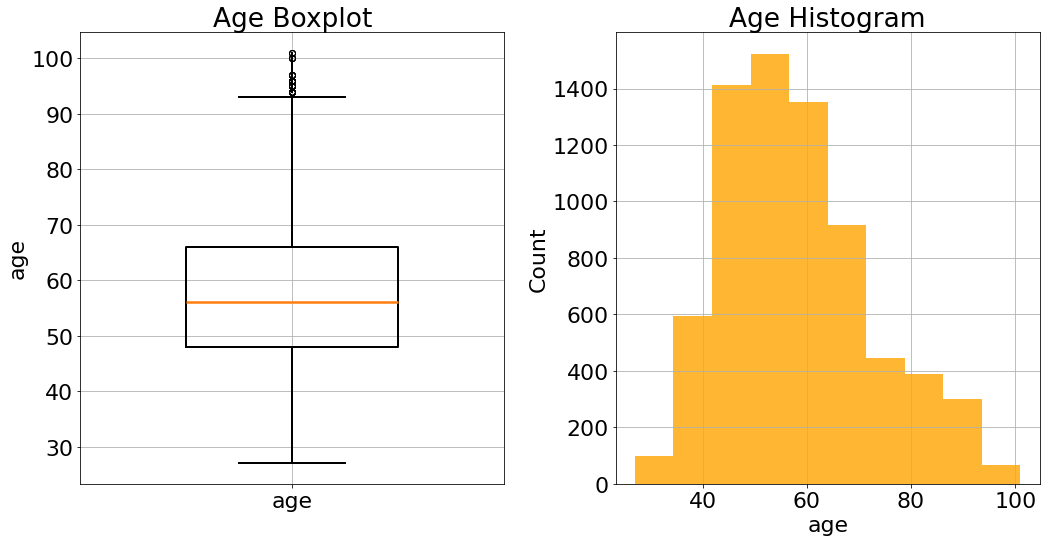

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

df["age"].plot.box(
    color=dict(medians='r'),
    widths=0.5,
    boxprops=dict(linestyle='-', linewidth=2),
    flierprops=dict(linestyle='-', linewidth=2),
    medianprops=dict(linestyle='-', linewidth=2.5),
    whiskerprops=dict(linestyle='-', linewidth=2),
    capprops=dict(linestyle='-', linewidth=2),
    grid=True,
    ax=ax1)
ax1.set_ylabel("age")
ax1.title.set_text("Age Boxplot")


ax2.hist(df["age"],color="orange",alpha=0.8)
ax2.set_ylabel("Count")
ax2.set_xlabel("age")
ax2.title.set_text("Age Histogram")
ax2.grid()

fig.tight_layout()

The results of these plots are a little scary- regardless of the idiom that "with age comes wisdom." Considering how difficult it has been to find data on congressional representatives, it will be interesting to see how age impacts a representative's polarity, especially with such a spread of data. The historgram on the right shows a right skew, and that tail is far longer than I think it should be. 

## A Brief note on DW-NOMINATE

Per [Poole and Rosenthal](https://www.jstor.org/stable/2111172):
- The first dimension picks up differences in **ideolology**, which is represented through the "liberal" vs. "conservative" (also referred to as "left" vs. "right") proportions throughout American history. Negative denotes a liberal disposition, positive a conservative.
- The second dimension picks up differences **within** the major political parties over slavery, currency, nativism, civil rights, and lifestyle issues during periods of American history.

For most purposes, the second dimension isn't as relevant. For the purposes of this study, we will focus on the first dimension. Using the 101st session from 1989 and our most recent 116th session of congress, we can see a little of what political science frequently (and unnecessarily) reminds us: [America is becoming more polarized](https://carnegieendowment.org/2023/09/05/polarization-democracy-and-political-violence-in-united-states-what-research-says-pub-90457). The difference is pretty striking visually:

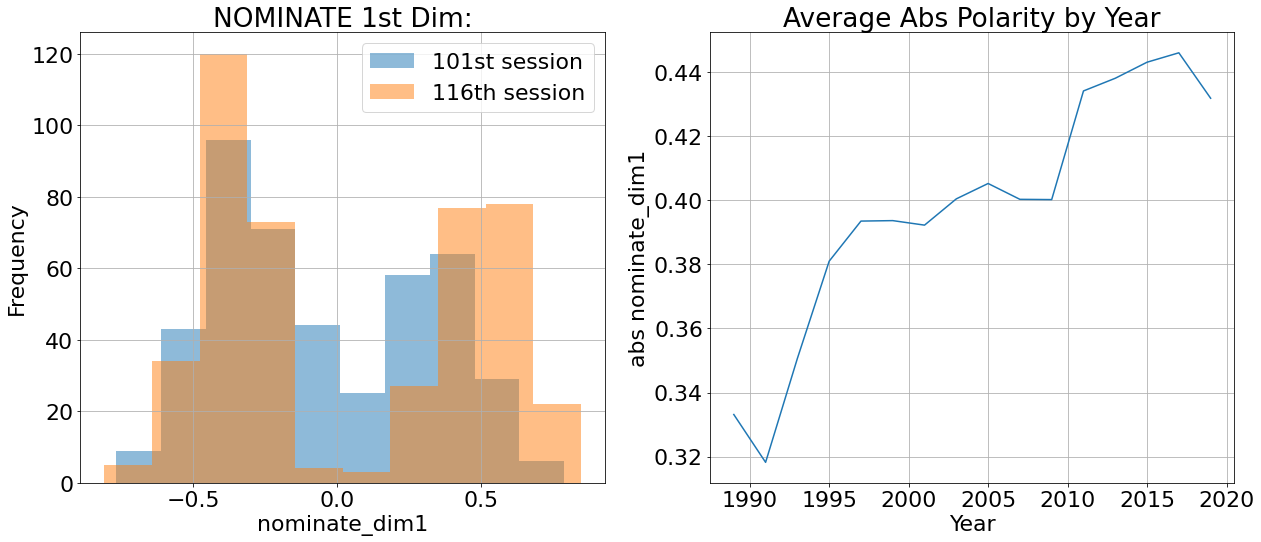

In [13]:
congress116 = df[df["congress"]==116]
congress101 = df[df["congress"]==101]

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(18,8))

ax1.set_xlabel("nominate_dim1")
ax1.set_ylabel("Frequency")
ax1.hist(congress101["nominate_dim1"], alpha=0.5, label="101st session")
ax1.hist(congress116["nominate_dim1"], alpha=0.5, label="116th session")
ax1.legend(loc='upper right')
ax1.title.set_text("NOMINATE 1st Dim:");
ax1.grid()

all_years = df["year_range"].unique()
year_mask = [df[df["year_range"]==year]["nominate_dim1"].abs().mean() for year in all_years]
all_years = [int(year[:4]) for year in all_years]
ax2.plot(all_years,year_mask)
ax2.set_xlabel("Year")
ax2.set_ylabel("abs nominate_dim1")
ax2.title.set_text("Average Abs Polarity by Year")
ax2.grid()

fig.tight_layout()
# fig.savefig(f"nominate_scores_over_time.png", dpi=96)

This basic extraction shows us a pretty striking relationship. The histogram on the left shows the trend away from a uniform distribution, with both peaks (both ideological centers) becoming tighter and tigher clusters away from 0.0 (ideological moderate). The line plot on the right demonstrates the average absolute ideological polarity (across the isle), which we can see also trends away from 0.0.

## New York Case Study

To illustrate the purpose of ideological scores and dive a little deeper into our representative data, let's visit New York. New York is a heavily liberal state ideologically speaking, mostly due to New York City. But upstate of NYC there are a good number of conservative voters, and we can see this reflected in the ideological plot below.

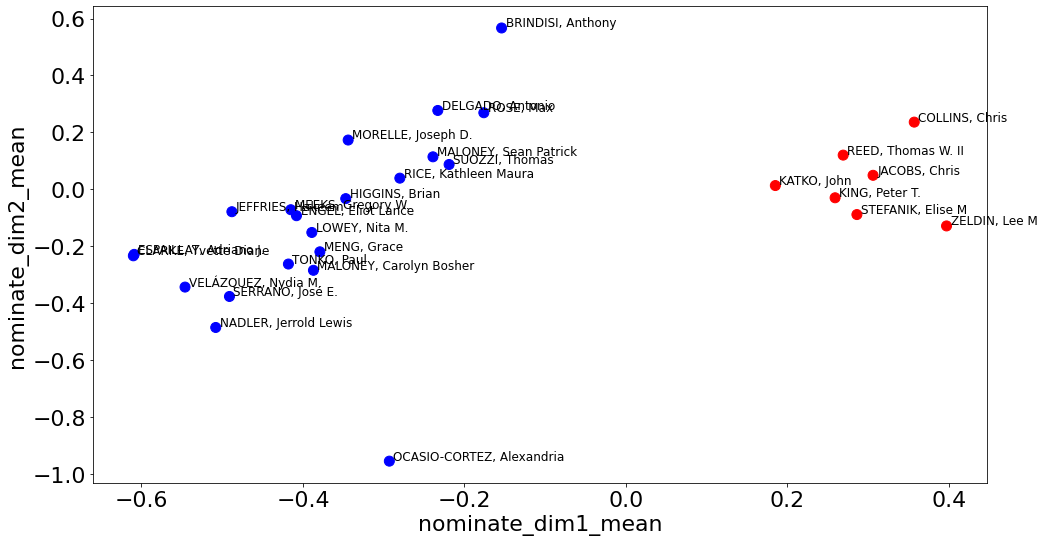

In [14]:

ny_116 = df.loc[(df["congress"] == 116) & (df["state_name"] == "New York")].groupby(["representative"], as_index=False)[["congress","nominate_dim1", "nominate_dim2", "party"]].agg(
    nominate_dim1_mean=('nominate_dim1', 'mean'),
    nominate_dim2_mean=('nominate_dim2', 'mean'),
    congress=('congress', 'first'),
    party=('party', 'first')
).sort_values("congress")

colors = {
    "Republican Party": "red",
    "Democratic Party": "blue"
}

party = {
    "Republican Party": "R",
    "Democratic Party": "D"
}

fig, ax = plt.subplots(figsize=(15, 8))

ax.scatter(x=ny_116['nominate_dim1_mean'], y=ny_116['nominate_dim2_mean'], c=ny_116['party'].map(colors), s=100)
ax.set_ylabel("nominate_dim2_mean")
ax.set_xlabel("nominate_dim1_mean")

delta = 0.005
for idx, row in ny_116.iterrows():
    ax.annotate(row['representative'], (row['nominate_dim1_mean']+delta, row['nominate_dim2_mean']+delta), fontsize=12)

fig.tight_layout()
# fig.savefig(f"ny_nominate_scores.png", dpi=96)


With this plot, the idea of NOMINATE scores becomes pretty obvious. There are pretty definite clusters here between party in both dimensions, with the NOMINATE 1st dimension denoting the liberal-conservative axis. As demonstrated by the graph, negative is liberal, and positive is conservative. As mentioned before, we will be exclusively focusing on the 1st dimension. 

There is another significant observation to be made here; poltical ideology is heavily polarized within a _state_. This means that our plan to use state demographics will fail to account for the diversity of political ideologies within a state, on a district level. This could result in some complications in our model, but it is a concession we will have to make due to lack of data.

## State Observations

We've seen that political ideology has significant variance within a state. But how do those patterns show up on a national level? To investigate, we will use choropleths utilizing state aggregates to understand the trends we have already observed, and draw conclusions about what a state says about a particular representative.

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

# Get geographical data for states from local geodata file:
states_geodata = geopandas.read_file('fresh_data/geodata/usa-states-census-2014.shp')

def build_choropleth(column="nominate_dim1", cmap="RdBu_r", all_time=False, manual_table=False, table=None, halfrange=None):
    """
    Builds choropleth according to specifications. 
    By default, generates polarity breakdown by state for 116th session of congress. 
    Params:
        - column: the column being aggregated on a state basis
        - cmap: cmap to be used for state coloration
        - all_time: flag denoting whether chart concerns all time, or a particular time period
        - manual_table: (sloppy) flag denoting intention to use a passed parameter 'table' instead of defaultly using global 'df' table
        - table: (sloppy) manual table to be used in place of global 'df' table
        - halfrange: param denoting the cmap centering norm to be used
    """

    # Get subset of states for 116th congress from global 'df' when no table is provided:
    if not manual_table:
        subset_116 = df[df["congress"]==116].groupby(["state_name"], as_index=False)[column].mean().sort_values(by=column)
        table = pd.merge(
            subset_116,
            states_geodata,
            left_on="state_name",
            right_on="NAME",
            how="left"
        )
    else:
        table = pd.merge(
            table,
            states_geodata,
            left_on="state_name",
            right_on="NAME",
            how="left"
        )
    # Build GeoDataFrame from current df:
    geo_df = geopandas.GeoDataFrame(table, geometry=table["geometry"])

    # Remove Hawaii and Alaska for whom we do not have geodata:
    hawaii_alaska_indices = geo_df[(geo_df["state_name"] == "Hawaii") | (geo_df["state_name"] == "Alaska")].index
    geo_df = geo_df.drop(hawaii_alaska_indices)


    # Normalize cmap from data:
    if halfrange:
        norm = mpl.colors.CenteredNorm(halfrange=halfrange)
    else:
        norm = None

    # Plot
    fig = plt.figure(1, figsize=(25,15));
    ax = fig.add_subplot();

    # Legend tweaks:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-1.8)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
    ax.set_title(f"Average {column} by State{', 2019-2021' if not all_time else ''}")

    ax.set_frame_on(False)
    geo_df.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1);
    us_map = geo_df.plot(
        ax=ax, 
        cmap=cmap, 
        norm=norm,
        figsize=(15,15), 
        column=column, 
        legend=True, 
        legend_kwds={"label": f"Mean {column}", "orientation": "vertical"},
        cax=cax,
    );

    return us_map.get_figure()

### Average NOMINATE by State

To examine the breakdown of ideology on a state level, we'll focus on the 116th session of congress. Averaging all of the NOMINATE scores for this session on a state level allows us to color-code our choropleth appropriately, with a blue-red color mapping- blue being liberal and red being conservative:

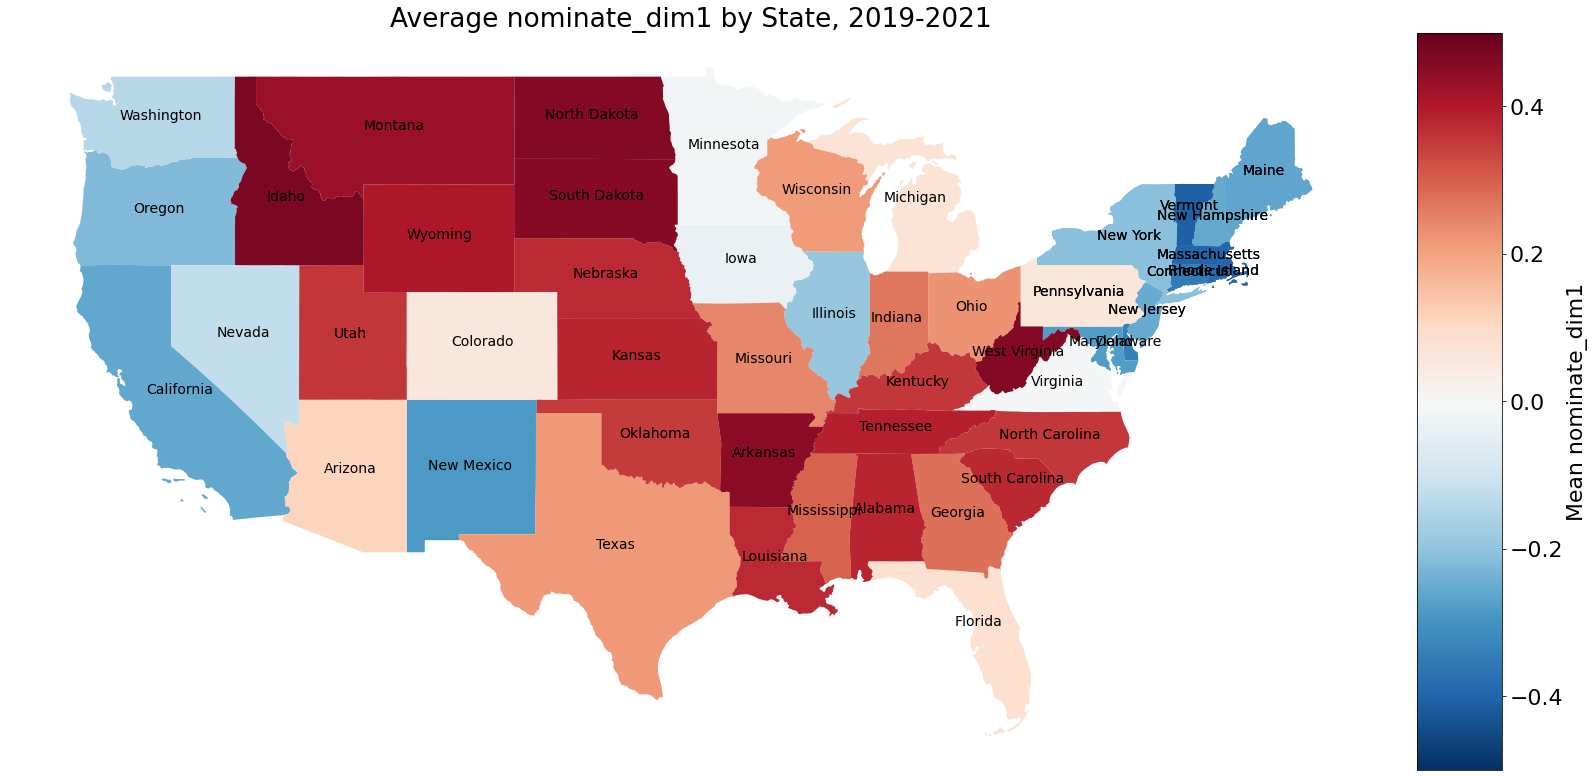

In [16]:
fig = build_choropleth(halfrange=0.5)
fig.tight_layout()

#### 

This plot demonstrates a pretty obvious conclusion for most Americans: Red states are conservative and blue states are liberal. With that, we can already make assumptions about our predictive power on a state level, liberals in blue states will get predicted fairly well, and conservatives will get predicted well in red states. Unfortunately, this also means that we will likely suffer predictively when a representative's ideologies don't line up with their state's average scores. 

Let's dive deeper into these metrics.

### Signed Democratic Party Change

To examine the impact of party, we will estimate the signed difference between the average nominate scores of 1989’s congress and 2019’s congressional sessions. **Negative** average changes denote a liberal polarity shift, and **positive** average changes denote a conservative polarity shift.



In [17]:
df["nominate_dim1_difference"] = df.groupby("state_name")["nominate_dim1"].transform(lambda x: np.ptp(x))

def get_party_map(party):
    print(f"Loading data for {party}:")
    party_df = df[df['party'] == party]
    state_ideology_change = pd.DataFrame(columns=["state_name", f"{party} Ideology Change 1989-2021"])
    for state in party_df["state_name"].unique():
        state_df = party_df[party_df["state_name"]==state][["congress", "nominate_dim1"]]
        congresses_avg_dim1 = state_df.groupby("congress", as_index=False)["nominate_dim1"].mean()

        congress_1 = congresses_avg_dim1[congresses_avg_dim1["congress"]==congresses_avg_dim1["congress"].min()]["nominate_dim1"].mean()
        congress_2 = congresses_avg_dim1[congresses_avg_dim1["congress"]==congresses_avg_dim1["congress"].max()]["nominate_dim1"].mean()

        signed_difference = 0

        if congress_1 > congress_2:
            signed_difference = -abs(congress_1 - congress_2)
        else: 
            signed_difference = abs(congress_2 - congress_1)

        d={'state_name': state, f"{party} Ideology Change 1989-2021": signed_difference} 
        state_ideology_change.loc[len(state_ideology_change)]=d

    state_ideology_change.head(3)

    fig = (build_choropleth(column=f"{party} Ideology Change 1989-2021", cmap="RdBu_r", all_time=True, manual_table=True, table=state_ideology_change, halfrange=1.0))
    return fig


Loading data for Democratic Party:


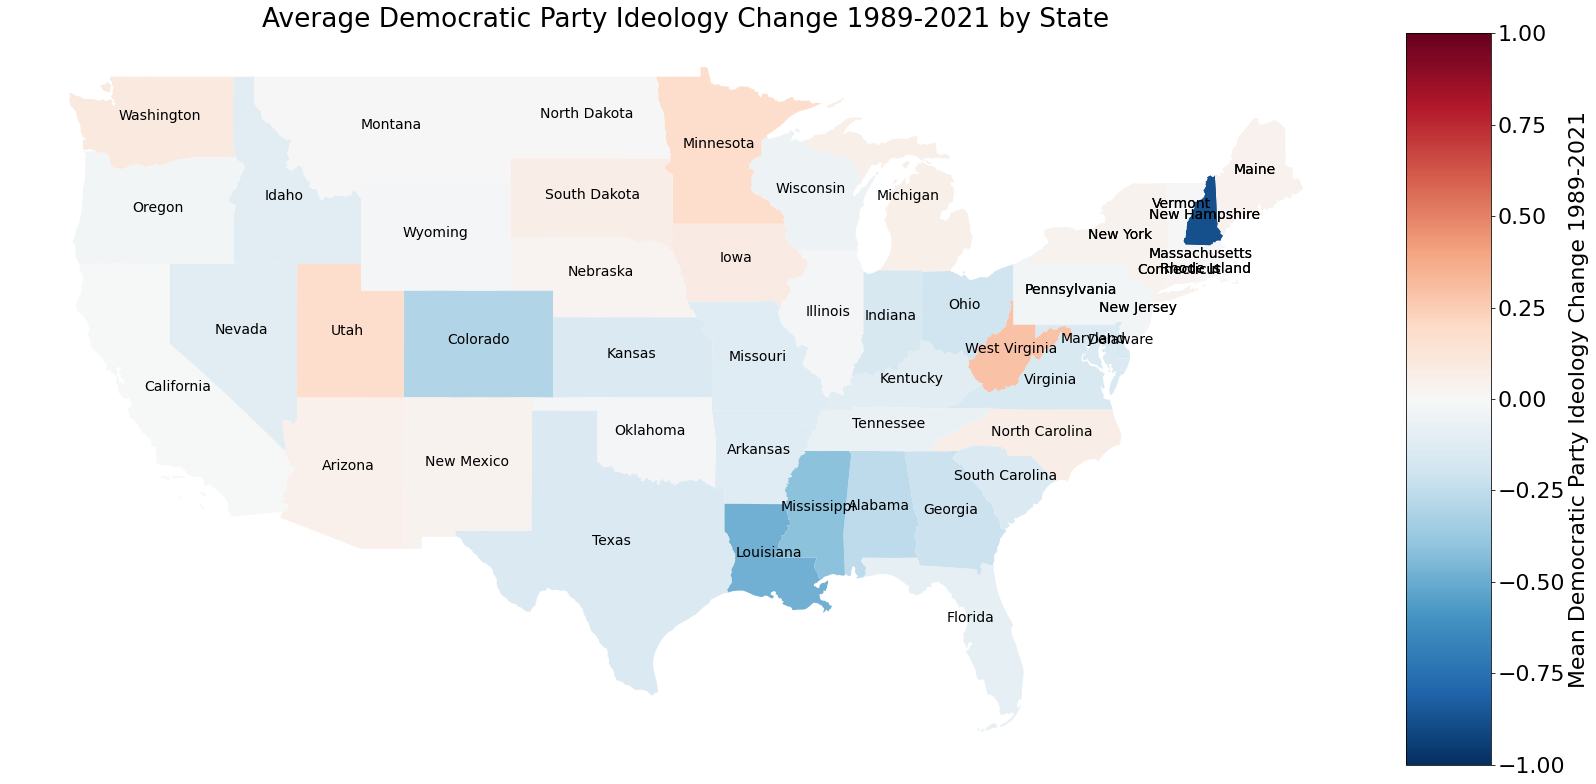

In [18]:
fig = get_party_map("Democratic Party")
fig.tight_layout()
fig.savefig(f"democrat_ideology_difference.png", dpi=96)

The graph gives us a little insight into the polarity we examined in our first few data explorations. As this graph only includes Democrats- we can see that Democratic representatives tend to get more liberal, with the exceptions being red states from our first choropleth. This tells us that party lines do not rule ideological shifts; Democrats get more liberal or more conservative based on their home state. This means that regardless of political affiliation, representatives from red states are more conservative, and representatives from blue states are more liberal. But it also tells us that these states get increasingly entrenched in their dominant ideology, another indicator of increasing polarity.

### Signed Republican Party Change

Computing the same for the Republican Party, we can see the same relationship:

Loading data for Republican Party:


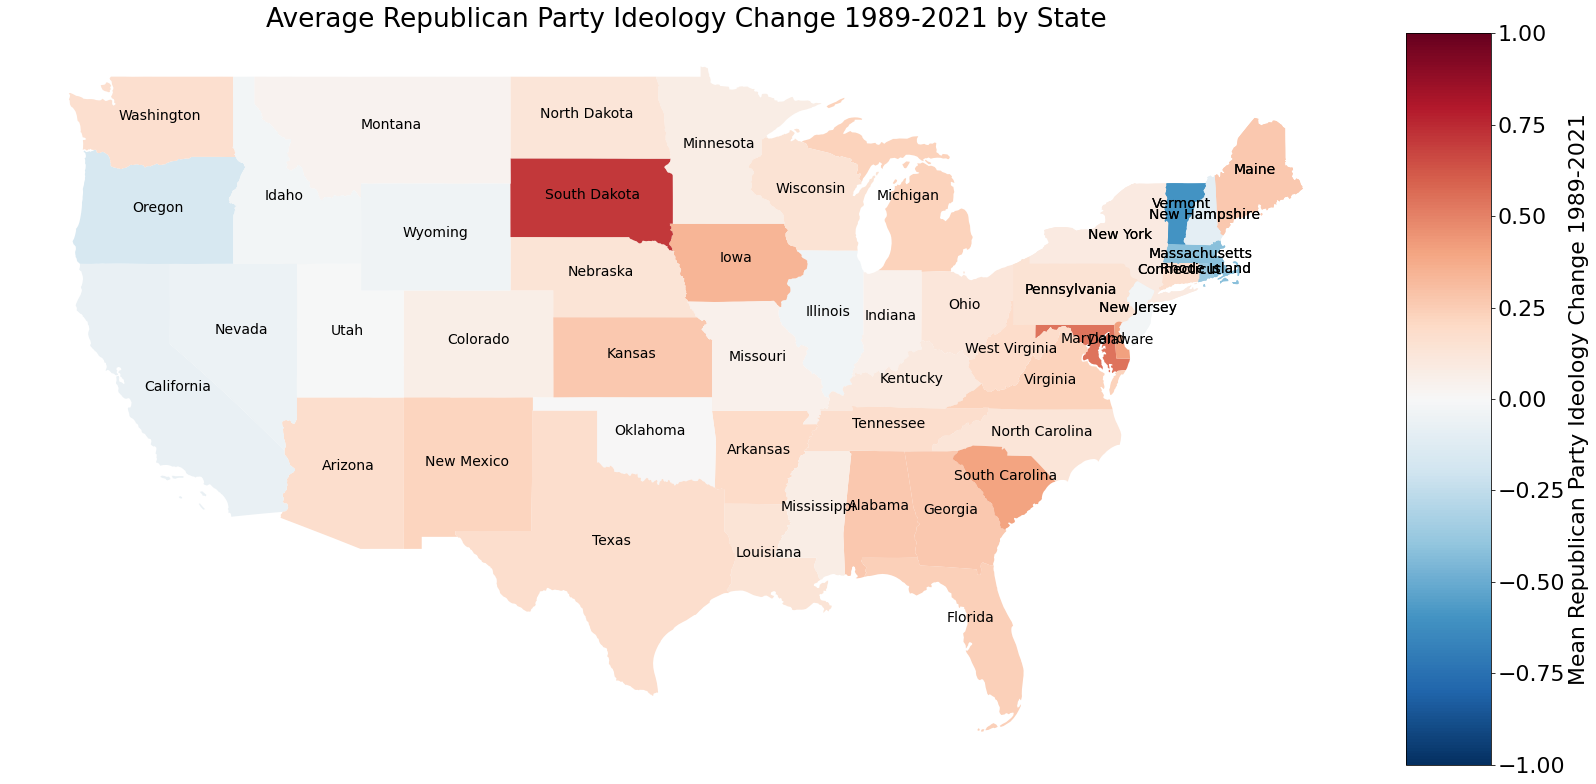

In [19]:
fig = get_party_map("Republican Party");
fig.tight_layout()
fig.savefig(f"republican_ideology_difference.png", dpi=96)

We can observe the same relationship for Republicans, with a serious shift towards conservatism in South Dakota.

### Correlation Heatmap

To evaluate our constituent data, let's focus on a few key features of each state's population and see how they correlate with our target, nominate_dim1. To do so, we'll use a correlation heatmap to visually depict relationships within our data. Ideally, we will be able to identify some patterns and make some decisions on feature selection. This enhances our understanding of variable interactions and gives us an idea of what direction we should take the model.

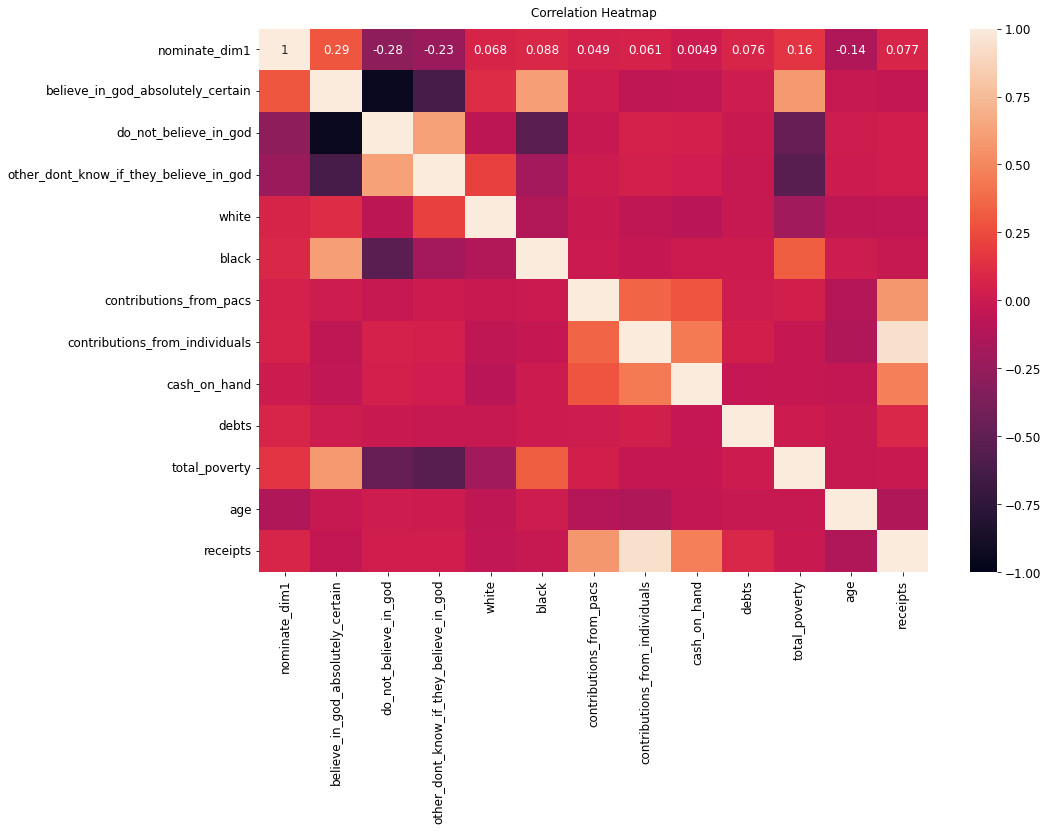

In [20]:
import seaborn as sns
import matplotlib

matplotlib.rcParams.update({'font.size': 12})

correlation_specifics = df[["nominate_dim1", "believe_in_god_absolutely_certain", "do_not_believe_in_god", "other_dont_know_if_they_believe_in_god", \
    "white", "black", "contributions_from_pacs", "contributions_from_individuals", "cash_on_hand", "debts", "total_poverty", "age", "receipts"]].corr()


fig, ax = plt.subplots(figsize=(15,10))   
ax =  sns.heatmap(correlation_specifics, vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
ax.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

matplotlib.rcParams.update({'font.size': 22})

There are no strong correlations, but hopefully our use of these metrics in tandem will aid in our modeling efforts. Some standout results: 
- believe_in_god_absolutely_certain has the highest positive correlation with our nominate scores, we can assume that this could help us in modeling
- personal finance data has a very small correlation with our nominate scores, so our predictions will likely suffer on a district level as anticipated
- age has a relatively high correlation with nominate score, this could also be helpful

### Single-Feature Regression

Using our highest correlation from the heatmap above, we will build a quick predictor to estimate nominate_dim1 without any other features:

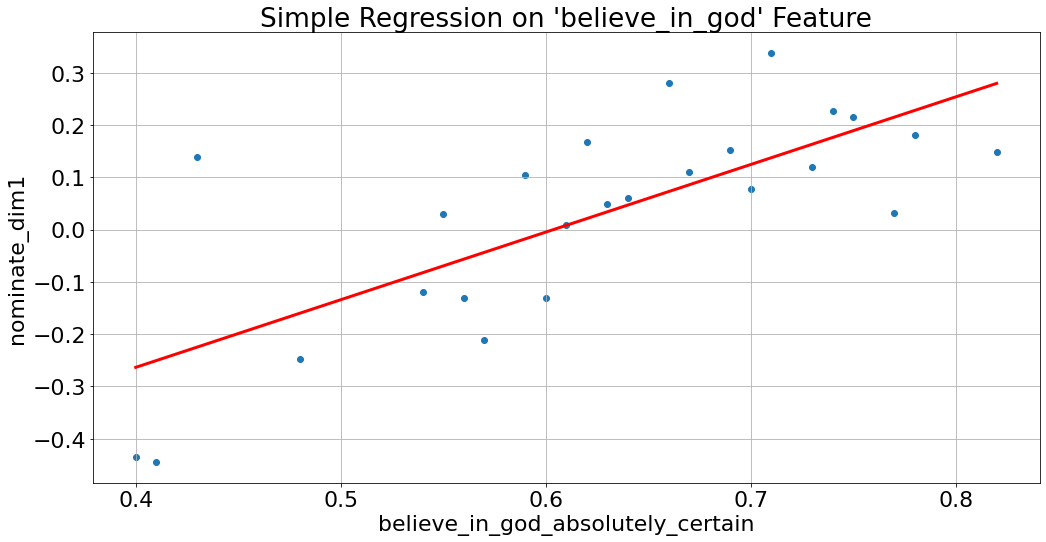

In [21]:
from sklearn.linear_model import LinearRegression

# df.plot.scatter(x="believe_in_god_absolutely_certain", y="nominate_dim1")

holy_df = df.groupby("believe_in_god_absolutely_certain", as_index=False)["nominate_dim1"].mean()

fig, ax = plt.subplots(figsize=(15,8))

ax.grid()
ax.scatter(x=holy_df["believe_in_god_absolutely_certain"], y=holy_df["nominate_dim1"])
ax.set_ylabel("nominate_dim1")
ax.set_xlabel("believe_in_god_absolutely_certain")
ax.set_title("Simple Regression on 'believe_in_god' Feature")

lr = LinearRegression()
lr.fit(np.array(holy_df["believe_in_god_absolutely_certain"]).reshape(-1,1), np.array(holy_df["nominate_dim1"]).reshape(-1,1))

# ax.plot()

regression = [lr.predict(np.array([belief]).reshape(-1,1)) for belief in holy_df["believe_in_god_absolutely_certain"].unique()]

regression = np.array(regression).reshape(-1,1)
ax.plot(holy_df["believe_in_god_absolutely_certain"].unique(), regression, color="red", linewidth=3);
# regression = [predict(model, year) for year in data_continent["year"].unique()]
#     plt.plot(data_continent["year"].unique(), regression, label=continent, color=cmap(color),linewidth=3)

fig.tight_layout()
# fig.savefig(f"holy_regression_batman.png", dpi=96)

# Machine Learning
***

## Data Preparation

We have observed some correlations and possible predictive power in our EDA, but for these first few predictive attempts, we'll be using most of our data. For the most part, the only excluded fields are metadata from merges, and unrelated fields like the second nominate dimension.

Additionally, some final cleaning is required to get our data into the appropriate shape for model use.

**Our models will aim to address two predictive tasks**:
- Predicting DW-NOMINATE Scores Nationally
- Predicting DW-NOMINATE Scores on the State Level

We will then take what our best performing models learn and extrapolate further patterns in the data. 

### Refactor Party

We are mostly interested in Republican/Democrat representatives, so we can configure this as a boolean where Republican is False and Democrat is True:

In [22]:
# Remove smaller parties or lack of party affiliation:
df = df[(df["party"] == "Republican Party") | (df["party"] == "Democratic Party")]

df["party"] = df["party"].apply(lambda x: 1 if "Democratic" in x else 0)

### Refactor Districts

Our districts are integer values which from a top-down perspective could have relationships with each other. This can impede model learning- the 5th California district has nothing to do with the 5th Wisconsin district. Districts must be understood within the context of their state, and this information is not presently captured by our data. To properly learn from districts, we will need to combine our state and district columns, and only then can we one-hot-encode. This will increase the dimensionality of our data significantly, but I believe it will aid in model learning.

In [23]:
df["district_code"] = df["state_name"].apply(lambda x: x.lower()) + "_district_" + df["district_code"].astype(str)

### Reshaping/Refactoring Data

We will use a functional implementation as to tweak what our model learns from down the line, and further investigate feature importances as well as necessity. The functional implementation accomplishes the following automatically:

**Refactor Int/Float**:
TensorFlow requires float32, which requires a minor refactor which you can see in the code below.

**Categorical One-Hot-Encoding**:
In order for our models to appropriately interpret and utilize our categorical features, we will need to one-hot encode each of them.

**Train/Test Split**:
I opted for a 90-10 train/test split arbitrarily, as our dataset is large enough that a 10% test set seems adequate for our purposes.

In [24]:
from sklearn.model_selection import train_test_split

# Default columns for learning (most of them):
columns_X = [
       ## representative data: 
       'state_name', 'district_code', 'party',
       'congress', 'year_range', 'born', 'age',
       'nominate_number_of_votes', 'running_as',
       'receipts', 'contributions_from_individuals', 'contributions_from_pacs',
       'contributions_and_loans_from_candidate', 'disbursements',
       'cash_on_hand', 'debts', 
       
       ## state data: 
       'total_poverty', 'white', 'black', 'hispanic', 'asian', 'multiple_races',

       # State data across years (only most recent data available):
       'believe_in_god_absolutely_certain', 'believe_in_god_fairly_certain',
       'believe_in_god_not_too_not_at_all_certain', 'believe_in_god_dont_know',
       'do_not_believe_in_god',

       'buddhist', 'catholic', 'evangelical_protestant', 'hindu',
       'historically_black_protestant', 'jehovahs_witness', 'jewish',
       'mainline_protestant', 'mormon', 'muslim', 'orthodox_christian',
       'unaffiliated_religious_nones', 
       
       # State data from bicennial 2020, 2010, 2000 as closest-match
       'population'
]

def prepare_data(columns_X=columns_X, columns_Y=[ 'nominate_dim1', 'nominate_dim2' ], manual_df=pd.DataFrame()):

       if len(manual_df) != 0:
              selected = manual_df
       else:
              selected = df
       
       y=selected[columns_Y[0]] # Only target first dimension
       X=selected[columns_X]

       int_cols = list(X.select_dtypes(include=[int]))
       X.loc[:, int_cols] = X[int_cols].astype("category")

       float64_cols = list(X.select_dtypes(include='float64'))
       X.loc[:,float64_cols] = X[float64_cols].astype('float32')

       y = y.astype('float32')

       X = pd.get_dummies(X, prefix=X.select_dtypes(include=[object, "category"]).columns, columns=X.select_dtypes(include=[object, "category"]).head(3).columns)

       return train_test_split(X,y,test_size=0.1)
       
x_train, x_test, y_train, y_test = prepare_data()

## Helper Functions

### Benchmarking

Below is a benchmarking function I wrote to quickly summarize the default scoring of a model and output the top feature importances. This will be handy when we run different tests on models and want to understand how they are progressing.

In [25]:
# Outputs relevant information about a model including default score and feature importances as a dataframe:
def benchmark_model(model):

    try:
        feature_importances = model.feature_importances_
    except:
        feature_importances = model.coef_

    feature_importances = pd.DataFrame({'importance': feature_importances}, index=x_train.columns).sort_values(by='importance', ascending=False)
    feature_importances["importance"] = feature_importances["importance"].apply(round, args=(4,))

    test_score = model.score(x_test, y_test)
    train_score = model.score(x_train, y_train)

    print(f"Train Score : { train_score }")
    print(f"Test Score  : { test_score }")
    display(feature_importances.head(10))
    return feature_importances

### Grid Search
In order to tune the hyperparameters of our chosen model, I opted to use GridSearchCV, which will find the best performing combinations of specified hyperparameters to better fit the model on the data. The function below allows for a custom estimator and parameters to be utilized.

Additionally, the search has been parameterized with 5-fold cross validation for each test. I stuck with the default 5 as I wanted to reduce training time while maximizing use of my training data.

In [26]:
from sklearn.model_selection import GridSearchCV

def grid_search(estimator, params):
    grid = GridSearchCV(estimator=estimator, param_grid=params, cv=2, n_jobs=-1, verbose=10)
    grid.fit(x_train, y_train)

    print()
    print("\n Results from Grid Search " )
    print("\n The best estimator across all searched params:\n",grid.best_estimator_)
    print("\n The best score across all searched params:\n",grid.best_score_)
    print("\n The best parameters across all searched params:\n",grid.best_params_)

    return grid

## Predicting DW-NOMINATE Nationally

### Model Selection

My approach in model selection is to do some surface level fitting on the training data with an assortment of models. I will select the highest default performers and tune their hyperparameters with grid searches to find my optimal model for this problem. We will repeat this process twice for both predictive tasks, 



In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def surface_level_test(model):
    model.fit(x_train,y_train)
    return round(model.score(x_train, y_train), 2), round(model.score(x_test, y_test), 2)

models = [
    ("LR", LinearRegression()),
    ("KNR", KNeighborsRegressor()),
    ("MLP", MLPRegressor()),
    ("ABR", AdaBoostRegressor()),
    ("GBR", GradientBoostingRegressor()),
    ("RFR", RandomForestRegressor())
]

for name, model in models:
    train, test = surface_level_test(model)
    print(f"- {name}: test: {test}")

- LR: test: 0.84
- KNR: test: 0.25
- MLP: test: -381314058.64
- ABR: test: 0.81
- GBR: test: 0.85
- RFR: test: 0.89


Surface-level training of the following algorithms found the following results:
- LinearRegression: 0.84
- TF-DNN (using MAE): 0.40 (not pictured above)
- KNNRegression: 0.11
- SKL-MLP: -6.4328207429 × 10^8 (I must have messed up training here)
- AdaBoost: 0.82
- GradientBoosting: 0.85
- RandomForestRegression: **0.90**

### Understanding scores

The regression models I intend to use have a default score* metric, which is the "coefficient of determination," defined as **one minus the residual sum of squares divided by the total sum of squares**. 1.0 is the best possible score, but scores can be negative (the model can be arbitrarily worse). The score is easily interpretable, providing a percentage of variance explained by the model relative to the total variance in the data.

*[Score](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.score)

### Feature Importance

Before hyperparameter tuning RandomForestRegression, I thought it prudent to do a few surface level examinations of feature importance to narrow our scope, and make some observations about the relationships in our data.
<br />

#### Linear Regression

First, let's take a preliminary look at the coefficients from a Linear Regression:

In [28]:
lr = LinearRegression().fit(x_train, y_train)
benchmark_model(lr);

Train Score : 0.8845451309693991
Test Score  : 0.8377113000912657


,importance
multiple_races,3.8771
white,1.8819
black,1.6825
hispanic,0.9363
state_name_Hawaii,0.7795
district_code_texas_district_36,0.4880
district_code_hawaii_district_1,0.4001
district_code_hawaii_district_2,0.3794
state_name_California,0.3386
party_0,0.2939


Linear Regression performs relatively well without tuning, and we can see it has observed a relationship between race and ideology, with "mulitple_races" by far the highest coefficient here. The recoded districts are also highly indicative of polarity according to the model, which was expected. party_0, which is the encoding for Republicans, is also relatively important.

<br />

#### RandomForestRegressor

Next, let's take a preliminary look at our feature importances from the base model:

In [29]:
default_model = RandomForestRegressor(random_state=42).fit(x_train, y_train)
benchmark_model(default_model);

Train Score : 0.9878833252817631
Test Score  : 0.8958334255255226


,importance
party_0,0.4398
party_1,0.3455
running_as_Incumbent,0.0265
born,0.0154
disbursements,0.0115
contributions_from_pacs,0.0108
age,0.0092
cash_on_hand,0.0083
contributions_from_individuals,0.0079
nominate_number_of_votes,0.0063


#### Analysis

Interestingly, the Random Forest Regressor (RFR) is interested in a very different set of features from those picked up in the Linear Regression (LR). With LR, we assume a linear relationship between our input and nominate scores. RFR on the other hand, is non-linear. It can capture much more complex relationships in the data. It is not immediately clear to me which approach is better, or which set of feature importances might be more accurate. 

We can observe here that _party_ is very important compared to the other top features, by a factor of ten. This makes sense from our EDA where party is a major indicator of ideology, but I was expecting to see a heavier importance on _location_, which we did observe in the LR. We have a large amount of historical data to demonstrate how a representative might lean, and I think a model would benefit from considering location more. I hypothesize that the polarization of representatives on a _district_ level prevents us from using _state_ data effectively, as I had feared in EDA. The model tries to make up the difference by using representative data, which has a sparse correlation with our target feature, but ends up relying on party to determine a member's ideology. 

These results are not bad, covering ~90% of our test set's variance is still a success. It would seem that our model is overfitting, but some hyperparameter tuning and data modification might be able to help alleviate this in later tests. The reliance on party should be limited. I am interested in how well we can predict without it. To see if my assumptions about the model's learning behavior in the face of state polarization variance are accurate, let's run another test. 

<br />

#### Training with State Data

Below is a subset of our data which includes exclusively state data. If my hypothesis is accurate, we will get a much lower score due to our reliance on representative data to understand polarity within a state.

In [30]:
test_columns = [
    'state_name',

    ## state data: 
    'total_poverty', 'white', 'black', 'hispanic', 'asian', 'multiple_races',

    # State data across years (only most recent data available):
    'believe_in_god_absolutely_certain', 'believe_in_god_fairly_certain',
    'believe_in_god_not_too_not_at_all_certain', 'believe_in_god_dont_know',
    'do_not_believe_in_god',

    'buddhist', 'catholic', 'evangelical_protestant', 'hindu',
    'historically_black_protestant', 'jehovahs_witness', 'jewish',
    'mainline_protestant', 'mormon', 'muslim', 'orthodox_christian',
    'unaffiliated_religious_nones', 
    
    # State data from bicennial 2020, 2010, 2000 as closest-match
    'population'
]

x_train, x_test, y_train, y_test = prepare_data(columns_X=test_columns)

In [31]:
default_model = RandomForestRegressor(random_state=42).fit(x_train, y_train)
benchmark_model(default_model);

Train Score : 0.21083301975954505
Test Score  : 0.17142562297893627


,importance
believe_in_god_absolutely_certain,0.2299
asian,0.1291
hispanic,0.0869
multiple_races,0.0863
total_poverty,0.0801
do_not_believe_in_god,0.0699
white,0.0584
population,0.0421
black,0.0395
orthodox_christian,0.0278


<br />

#### Same test, but with district_code

In [32]:
x_train, x_test, y_train, y_test = prepare_data(columns_X=test_columns+["district_code"])
default_model = RandomForestRegressor(random_state=42).fit(x_train, y_train)
state_forest_importances = benchmark_model(default_model);

Train Score : 0.836838178806119
Test Score  : 0.6523881927066166


,importance
believe_in_god_absolutely_certain,0.0648
hispanic,0.0349
asian,0.0346
multiple_races,0.0332
total_poverty,0.0287
white,0.0283
do_not_believe_in_god,0.0247
black,0.0205
population,0.0185
orthodox_christian,0.0134


Evidently my hypothesis is accurate and without data on the representative, the model suffers substantially. Interestingly, we can see the highest correlation feature we studied in our earlier EDA (believe_in_god_absolutely_certain) is the most important feature in this space. 

In the second test, where "district_code" was added, we can see a substantial improvement to model score, leaping from ~0.16 to ~0.68. While individually single districts are not important, districts as a whole are very important in model computation. We can observe this better by aggregating all district importances:

In [33]:
im = state_forest_importances.reset_index().rename({"index":"feature"}, axis=1)
district_mask = im["feature"].apply(lambda x: True if "district" in x else False)
print("Aggregate district importance:", im[district_mask]["importance"].sum())

Aggregate district importance: 0.6579



Consideration of the entire feature space is important, especially due to the impacts of constituents on their representatives. But without district-level data, it appears that some of our state data is not aiding our modeling process. To evaluate, we'll need another test (next section).

<br />

#### Training with Representative Data

Below is a subset of our data which includes exclusively representative data, as well as state. If my hypothesis is accurate, we will get similar score to our full dataset due to our reliance on representative data to understand polarity within a state.


In [34]:
test_columns = [
    ## representative data: 
    'state_name', 'district_code', 'party',
    'congress', 'year_range', 'born', 'age',
    'nominate_number_of_votes', 'running_as',
    'receipts', 'contributions_from_individuals', 'contributions_from_pacs',
    'contributions_and_loans_from_candidate', 'disbursements',
    'cash_on_hand', 'debts', 
]

x_train, x_test, y_train, y_test = prepare_data(columns_X=test_columns)

In [35]:
default_model = RandomForestRegressor(random_state=42).fit(x_train, y_train)

benchmark_model(default_model);

Train Score : 0.9860502023538475
Test Score  : 0.9110205010177842


,importance
party_0,0.4056
party_1,0.3743
running_as_Incumbent,0.0266
born,0.0175
contributions_from_pacs,0.0153
disbursements,0.0141
age,0.0125
cash_on_hand,0.0107
contributions_from_individuals,0.0090
nominate_number_of_votes,0.0088


We achieve comparable performance to our initial run, it seems state data isn't helping us as much as hoped (but just as much as expected). We can modify our final feature selection prior to hyperparameter tuning accordingly, with the highest importance features from state computations and all of our information on representatives.

In [36]:
district_mask = im["feature"].apply(lambda x: False if "district" in x or "state" in x else True) # remove districts
list(im[district_mask & im["importance"]>0].sort_values(by="importance",ascending=False)[:15]["feature"])

['believe_in_god_absolutely_certain',
 'hispanic',
 'asian',
 'multiple_races',
 'total_poverty',
 'white',
 'do_not_believe_in_god',
 'black',
 'population',
 'orthodox_christian',
 'believe_in_god_fairly_certain',
 'mormon',
 'believe_in_god_not_too_not_at_all_certain',
 'muslim',
 'believe_in_god_dont_know']

In [37]:
important_columns = [
    'state_name', 'district_code', 'party',
    'congress', 'year_range', 'born', 'age',
    'nominate_number_of_votes', 'running_as',
    'receipts', 'contributions_from_individuals', 'contributions_from_pacs',
    'contributions_and_loans_from_candidate', 'disbursements',
    'cash_on_hand', 'debts', 

    # Top state data:
    'total_poverty', 'white', 'black', 'hispanic', 'asian', 'multiple_races',

    # State data across years (only most recent data available):
    'believe_in_god_absolutely_certain', 'believe_in_god_fairly_certain',
    'believe_in_god_not_too_not_at_all_certain', 'do_not_believe_in_god',
    'jewish', 'mormon', 'muslim', 'orthodox_christian',
    
    # State data from bicennial 2020, 2010, 2000 as closest-match
    'population'
]
x_train, x_test, y_train, y_test = prepare_data(columns_X=important_columns)

### RFR Grid Search

With our narrowed dimensional space, we can commence hyperparameter fine tuning. I'm interested in testing RFR, experimenting with regression models, and testing GBR, the third place contender from my model selection. The below parameters were chosen after some quick research, and a few experiments which lasted several hours. I have removed the tests which lasted longer than 30 minutes for the sake of readability, the models you see below are the best of my tests.

In [38]:
from sklearn.ensemble import RandomForestRegressor

rfr_params = { 
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 4, 8],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400]
}

# grid_rfr = grid_search(RandomForestRegressor(), rfr_params)

#### Best Model:

In [39]:
random_forest = RandomForestRegressor( bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10,n_estimators=400)
random_forest.fit(x_train,y_train)
print("Train:",random_forest.score(x_train, y_train))
print("Test :", random_forest.score(x_test, y_test))

Train: 0.9619109831227648
Test : 0.903023366696665


### Linear Models

I chose the following regression models from sklearn to see if there would be any improvement, but they both perform similarly on this data:

In [40]:
from sklearn.linear_model import LinearRegression, BayesianRidge

linear_models = [
    ("LR" , LinearRegression()), 
    ("BR" , BayesianRidge()), 
]

print("name : test score")
for name, model in linear_models:
    model.fit(x_train, y_train)
    print(f"{name} : {model.score(x_test, y_test)}")

name : test score
LR : 0.8458511553496137
BR : 0.8447235104339583


#### Best Linear Model:

In [41]:
linear_regression = LinearRegression()

linear_regression.fit(x_train,y_train)
print("Train:",linear_regression.score(x_train, y_train))
print("Test :", linear_regression.score(x_test, y_test))

Train: 0.8831674660793728
Test : 0.8458511553496137


### AdaBoostRegressor Grid Search
I have arbitrarily chosen the following hyperparameters to be tested in a unique instantiation of a AdaBoostRegressor (ABR). As a warning, the following code takes around 25 minutes to run.

In [42]:
from sklearn.ensemble import AdaBoostRegressor

abr_parameters = {
    'n_estimators':[10, 50,250,500,1500],
    'learning_rate':[0.01,0.1,0.5]
}

# grid_ABR = grid_search(AdaBoostRegressor(), abr_parameters)

#### Best Model:

In [43]:
adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=0.1)

adaboost.fit(x_train,y_train)
print("Train:",adaboost.score(x_train, y_train))
print("Test :", adaboost.score(x_test, y_test))

Train: 0.8352990798012934
Test : 0.8291588750557128


### GradientBoostRegressor Grid Search
I have arbitrarily chosen the following hyperparameters to be tested in a unique instantiation of a GradientBoostRegressor (GBR). As a warning, the following code takes around 25 minutes to run.

In [44]:
gbr_parameters = {
    'learning_rate': [0.01,0.02,0.03,0.04],
    'subsample'    : [0.9, 0.5, 0.2, 0.1],
    'n_estimators' : [50, 100,200,500,1000, 1500],
    'max_depth'    : [4,6,8,10]
}

# grid_GBR = grid_search(GradientBoostingRegressor(), gbr_parameters)

#### Best Model: 

In [45]:
final_model = GradientBoostingRegressor(learning_rate=0.02, max_depth=6, n_estimators=200, subsample=0.5)
final_model.fit(x_train,y_train)
print("Train:",final_model.score(x_train, y_train))
print("Test :", final_model.score(x_test, y_test))

Train: 0.9295710757446188
Test : 0.8774457517921463


### NOMINATE Predictor Final Model

The results of the grid search yielded the following model, which upon instantiation (which takes approximately 1.5 minutes), gives us the following accuracies:

In [46]:
final_model = RandomForestRegressor(bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=10,n_estimators=400)
final_model.fit(x_train,y_train)
print("Train:",final_model.score(x_train, y_train))
print("Test :", final_model.score(x_test, y_test))

Train: 0.9615331758350462
Test : 0.9030983723381067


In [47]:
from sklearn import metrics

y_pred = final_model.predict(x_test)
y_true = y_test

print("Coefficient of Determination", metrics.r2_score(y_pred, y_true))
print("MSE:", metrics.mean_squared_error(y_pred, y_true))
print("MAPE:", metrics.mean_absolute_percentage_error(y_true, y_pred)) # sensitive to relative errors

Coefficient of Determination 0.8879212303165057
MSE: 0.017437575862430523
MAPE: 0.25425984847481004


#### Sample prediction:

In [48]:
# index of test observation
test_loc = x_test.iloc[[42]].index[0]
print("Test set index:", test_loc)

# Find corresponding index in original dataframe:
test_rep = df.loc[[test_loc]]
test_rep

Test set index: 6577


,representative,state_name,district_code,party,congress,year_range,born,age,nominate_dim1,nominate_dim2,...,historically_black_protestant,jehovahs_witness,jewish,mainline_protestant,mormon,muslim,orthodox_christian,unaffiliated_religious_nones,population,nominate_dim1_difference
6577,"KUSTOFF, David",Tennessee,tennessee_district_8,0,115,2017-2019,1966.0,51.0,0.537,0.394,...,0.03,0.01,0.01,0.02,0.01,0.02,0.01,0.01,6346105.0,1.112


In [49]:
# example prediction:

y_pred = final_model.predict(x_test.iloc[[42]])[0]
y_true = y_test.iloc[[42]].values[0]

print(f"representative: {test_rep['representative'].values[0]}")
print(f"republican, {test_rep['congress'].values[0]}th session of congress")
print("\tpredicted:", y_pred)
print("\ttrue y   :", y_true)

representative: KUSTOFF, David
republican, 115th session of congress
	predicted: 0.5193699933865137
	true y   : 0.537


## Predicting DW-NOMINATE Statewide


### Florida Comparison
For this task, we will use a default Linear Regression and see how score behaves on a state level compared to nationally. Let's examine Florida, which is a battleground state and thus full of ideological variance.

In [55]:
def get_state_training(state):
    state_df = df[df["state_name"]==state].reset_index(drop=True)
    return prepare_data(important_columns, manual_df=state_df)

In [62]:
x_train, x_test, y_train, y_test = get_state_training("Florida")

In [63]:
flr = LinearRegression()
flr.fit(x_train, y_train)
flr.score(x_train, y_train)

print("Train:",flr.score(x_train, y_train))
print("Test :", flr.score(x_test, y_test))

Train: 0.8356847525627549
Test : 0.6296757699975623


The linear regression seems to suffer when we restrict its training data to Florida, despite our scoring on a Florida test set. This could be because Florida is a battleground state and the ideological polarity is very high. As a result, a model learning from representative data alone (as state data applies to all representatives regardless of ideology) will suffer in battleground states. To compare, let's try the same experiment in a state which leans liberal or conservative.

### New York Comparison

Florida is a battleground state. Let's take a look at a decidedly blue state, New York. From our EDA we saw that there is still ideological variance, but the state leans very blue.

In [64]:
x_train, x_test, y_train, y_test = get_state_training("New York")

nylr = LinearRegression()
nylr.fit(x_train, y_train)
nylr.score(x_train, y_train)

print("Train:",nylr.score(x_train, y_train))
print("Test :", nylr.score(x_test, y_test))

Train: 0.829500006695905
Test : 0.8143464623695067


This prediction verifies our hypothesis. It seems that predictive power in battleground states is difficult because of the large variance of ideology across the state. In a blue state like NY, our state demographics data is more often applicable to representatives, since most representatives are liberal. In Florida where there is a pretty even split, state data cannot explain the variance as well, and the model suffers. 

An excellent next step for this study would be to find some source of demographics data on a more local level.

# Conclusion

By using historical nominate scores we are able to estimate the ideology of a representative based on a small collection of their data and information about their constituents. Covering around 90% of the variance, we are able to predict the ideology of a representative without their voting data. This meas that we can summarize a representative's ideology in multidimensional space and make predictions about their future votes.

We have also demonstrated the importance of constituents in the ideology of their representatives. Despite only using state data, national trends allow us to observe some of the relationships between demographics of constituents and their representatives' ideology. Our regression coefficients and feature importances demonstrate the significance of more than just surface level observations like location or political party. We are able to observe the impact of religion, the distribution of race, and representative finance in ideological scores.

The increasing polarization in the U.S. is a dangerous trend. In an ideal world, we as constiutents would better understand our representatives and their motives. The effort of researching and keeping tabs on representatives is not something most people want to do, and DW-NOMINATE scores are only computable for incumbent representatives. In this project, we have managed to estimate DW-NOMINATE scores without voting records, enabling the quantification of representatives who are running for office for the first time, or do not have substantial voting records. 

A major flaw of this project is that our model suffers when predicting ideology in battleground states like Florida. Where ideological variance does not lean in one direction or the other, the model is unable to extrapolate state data onto representatives, and we miss out on predictive power. Another side-effect is that in states like NY, where ideological variance leans blue, we are likely to miss out on conservative predictions. Gathering district-level data would allow our model to rely less on representative data and make better estimations of polarity. 